In [1]:
## Credit to raddar:
# https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
from collections import Counter
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from IPython.display import display
pd.options.display.max_columns = None
from boruta import BorutaPy

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def Mode(x):
    # if the most frequent & 2nd most frequent one have the same frequencies, take the bigger one
    counts = Counter(x)
    tup = sorted(counts.items(), key=lambda kv: kv[1])
    return tup[-1][0]
    
def Range(x):
    return max(x) - min(x)

def fquartile(x):
    return np.nanpercentile(x, 25)

def tquartile(x):
    return np.nanpercentile(x, 75)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

DEFAULT_PARAMS = {'boosting': 'gbdt',
                  'metric': 'rmse',
                  'n_jobs': 6,
                 'learning_rate': 0.01,
                 'feature_fraction': 0.5,
                 'num_leaves': 88,
                 'min_data_in_leaf': 29,
                 'max_depth': 8,
                 'reg_alpha': 30,
                 'reg_lambda': 13,
                 'subsample': 0.9509456621468215,
                 'colsample_bytree': 0.6121367834623093,
                 'min_child_weight': 14,
                 'min_split_gain': 24,
                 'bagging_freq': 8,
                 'bagging_fraction': 0.9199384773431196}

FEATS_EXCLUDED = ['target', 'card_id', 'outliers', 'first_active_month',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0', 'hist_purchase_date_ptp', 'new_purchase_date_ptp'
                 ]

def kfold_lightgbm(train_df, test_df, num_folds=4, params=DEFAULT_PARAMS, stratified=True, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month_month', 'first_active_quarter']

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        params['verbose'] = -1
        
        params['seed'] = int(2**n_fold)
        params['bagging_seed'] = int(2**n_fold)
        params['drop_seed'] = int(2**n_fold)
        
        model = lgb.train(params, lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          num_boost_round=20000,
                          early_stopping_rounds= 500,
                          verbose_eval=100)
        oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
        sub_preds += model.predict(test_df[feats], num_iteration=model.best_iteration) / num_folds
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del model, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    print('RMSE is {}'.format(rmse(oof_preds, train_df['target'])))
    return sub_preds, feature_importance_df

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(12, 50))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    return best_features.sort_values(by="importance", ascending=False)


Using TensorFlow backend.
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


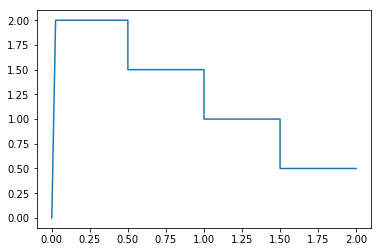

In [8]:
plt.plot([0,0.025,0.5,0.5,1,1,1.5,1.5,2], [0,2,2,1.5,1.5,1,1,0.5,0.5])

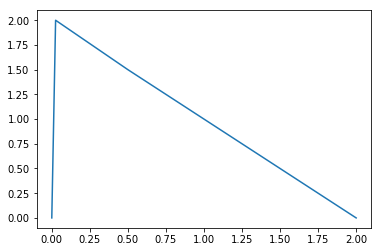

In [7]:
plt.plot([0,0.025,0.5,1,1.5,2], [0,2,1.5,1,0.5,0])

In [7]:
train_df = pd.read_hdf('Elo_new.h5', 'train_df_CV_36435')
test_df = pd.read_hdf('Elo_new.h5', 'test_df_CV_36435')
train_df.isna().sum().sum()

0

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def objective(trial, repeated=True):
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month_month', 'first_active_quarter']
    if repeated:
        folds = RepeatedKFold(n_splits=4, n_repeats=1, random_state=326)
    else:
        folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=326)
        
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        print('Fold {} begins....'.format(n_fold+1))
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'n_jobs': 5, 
                 'boosting_type': 'gbdt',
                 'seed':int(2**n_fold), 'drop_seed': int(2**n_fold), 'feature_fraction_seed': int(2**n_fold),
                 'learning_rate': trial.suggest_uniform('learning_rate', 1e-3, 1.5e-3),
                 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.6),
                 'num_leaves': trial.suggest_int('num_leaves', 60, 120),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
                 'max_depth': trial.suggest_int('max_depth', 6,12),
                 'reg_alpha': trial.suggest_uniform('reg_alpha', 25, 50),
                 'reg_lambda': trial.suggest_uniform('reg_lambda', 10, 30),
                 'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
                 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
                 'min_child_weight': trial.suggest_int('min_child_weight', 10, 50),
                 'min_split_gain': trial.suggest_int('min_split_gain', 10, 50),
                }
        param['bagging_freq'] = trial.suggest_int('bagging_freq', 6, 10)
        param['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.5, 1.0)
        param['bagging_seed'] = int(2**n_fold)
    
        clf = lgb.train(param, lgb_train, 40000, valid_sets=[lgb_train, lgb_test],
                        verbose_eval=500, early_stopping_rounds=500)
            
        oof_preds[valid_idx] = clf.predict(train_df.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
        
        del clf, train_x, train_y, valid_x, valid_y, train_idx, valid_idx
        gc.collect()
    
    RMSE = rmse(oof_preds, train_df['target'])
    print('RMSE is: {}'.format(RMSE))
    return RMSE
    

In [12]:
### DO THIS LATER

In [ ]:
%%time

study = optuna.create_study()
study.optimize(objective, n_trials=100)
print('study.best_params: \t')
print(study.best_params)
print('study.best_value: \t')
print(study.best_value)
print('study.best_trial.user_attrs: \t')
print(study.best_trial.user_attrs)

optuna_lgb = study.trials_dataframe()
optuna_lgb.to_csv("optuna_lgb_repeatedkfold.csv")

Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67808	valid_1's rmse: 3.81378
[1000]	training's rmse: 3.61202	valid_1's rmse: 3.77129
[1500]	training's rmse: 3.57262	valid_1's rmse: 3.7532
[2000]	training's rmse: 3.54569	valid_1's rmse: 3.74421
[2500]	training's rmse: 3.52422	valid_1's rmse: 3.73914
[3000]	training's rmse: 3.50551	valid_1's rmse: 3.73595
[3500]	training's rmse: 3.48884	valid_1's rmse: 3.73389
[4000]	training's rmse: 3.47416	valid_1's rmse: 3.73264
[4500]	training's rmse: 3.45975	valid_1's rmse: 3.73167
[5000]	training's rmse: 3.44629	valid_1's rmse: 3.73082
[5500]	training's rmse: 3.43383	valid_1's rmse: 3.73038
[6000]	training's rmse: 3.42192	valid_1's rmse: 3.73018
[6500]	training's rmse: 3.4103	valid_1's rmse: 3.73007
[7000]	training's rmse: 3.39981	valid_1's rmse: 3.72983
[7500]	training's rmse: 3.3895	valid_1's rmse: 3.72975
[8000]	training's rmse: 3.37965	valid_1's rmse: 3.72978
Early stopping, best iterat

[I 2019-02-10 01:59:44,292] Finished a trial resulted in value: 3.644453636082464. Current best value is 3.644453636082464 with parameters: {'learning_rate': 0.0014895430426130475, 'feature_fraction': 0.26168898533447715, 'num_leaves': 111, 'min_data_in_leaf': 39, 'max_depth': 6, 'reg_alpha': 25.75518672965181, 'reg_lambda': 11.062272160280116, 'subsample': 0.9063709599610197, 'colsample_bytree': 0.581003265371953, 'min_child_weight': 27, 'min_split_gain': 17, 'bagging_freq': 8, 'bagging_fraction': 0.7565988931130243}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68122	valid_1's rmse: 3.83363
[1000]	training's rmse: 3.5981	valid_1's rmse: 3.78947
[1500]	training's rmse: 3.53994	valid_1's rmse: 3.76764
[2000]	training's rmse: 3.49491	valid_1's rmse: 3.7554
[2500]	training's rmse: 3.46088	valid_1's rmse: 3.74852
[3000]	training's rmse: 3.43401	valid_1's rmse: 3.74419
[3500]	training's rmse: 3.41343	valid_1's rmse: 3.74138
[4000]	training's rmse: 3.3974	valid_1's rmse: 3.73975
[4500]	training's rmse: 3.38586	valid_1's rmse: 3.73872
[5000]	training's rmse: 3.37607	valid_1's rmse: 3.73806
[5500]	training's rmse: 3.36843	valid_1's rmse: 3.73759
[6000]	training's rmse: 3.36172	valid_1's rmse: 3.73722
[6500]	training's rmse: 3.3563	valid_1's rmse: 3.73691
[7000]	training's rmse: 3.35197	valid_1's rmse: 3.7367
[7500]	training's rmse: 3.34817	valid_1's rmse: 3.73657
[8000]	training's rmse: 3.34533	valid_1's rmse: 3.73645
[8500]	training's rmse: 3.342

[I 2019-02-10 02:24:41,052] Finished a trial resulted in value: 3.648869121282759. Current best value is 3.644453636082464 with parameters: {'learning_rate': 0.0014895430426130475, 'feature_fraction': 0.26168898533447715, 'num_leaves': 111, 'min_data_in_leaf': 39, 'max_depth': 6, 'reg_alpha': 25.75518672965181, 'reg_lambda': 11.062272160280116, 'subsample': 0.9063709599610197, 'colsample_bytree': 0.581003265371953, 'min_child_weight': 27, 'min_split_gain': 17, 'bagging_freq': 8, 'bagging_fraction': 0.7565988931130243}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70303	valid_1's rmse: 3.83321
[1000]	training's rmse: 3.64021	valid_1's rmse: 3.78788
[1500]	training's rmse: 3.60134	valid_1's rmse: 3.76522
[2000]	training's rmse: 3.57393	valid_1's rmse: 3.75253
[2500]	training's rmse: 3.55331	valid_1's rmse: 3.74535
[3000]	training's rmse: 3.53674	valid_1's rmse: 3.74058
[3500]	training's rmse: 3.52283	valid_1's rmse: 3.73754
[4000]	training's rmse: 3.51062	valid_1's rmse: 3.73553
[4500]	training's rmse: 3.49969	valid_1's rmse: 3.73401
[5000]	training's rmse: 3.48947	valid_1's rmse: 3.73305
[5500]	training's rmse: 3.48005	valid_1's rmse: 3.73222
[6000]	training's rmse: 3.47198	valid_1's rmse: 3.73173
[6500]	training's rmse: 3.46376	valid_1's rmse: 3.73127
[7000]	training's rmse: 3.45622	valid_1's rmse: 3.73103
[7500]	training's rmse: 3.44932	valid_1's rmse: 3.73081
[8000]	training's rmse: 3.44283	valid_1's rmse: 3.73065
[8500]	training's rmse: 

[I 2019-02-10 03:10:38,219] Finished a trial resulted in value: 3.643924466525311. Current best value is 3.643924466525311 with parameters: {'learning_rate': 0.0010407266515291196, 'feature_fraction': 0.5609548642454916, 'num_leaves': 66, 'min_data_in_leaf': 39, 'max_depth': 6, 'reg_alpha': 45.37212627559767, 'reg_lambda': 24.971457879249932, 'subsample': 0.8407994619904292, 'colsample_bytree': 0.7565109789579871, 'min_child_weight': 32, 'min_split_gain': 29, 'bagging_freq': 8, 'bagging_fraction': 0.8588857868277737}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66255	valid_1's rmse: 3.8205
[1000]	training's rmse: 3.57499	valid_1's rmse: 3.77812
[1500]	training's rmse: 3.51477	valid_1's rmse: 3.75884
[2000]	training's rmse: 3.46975	valid_1's rmse: 3.74905
[2500]	training's rmse: 3.43355	valid_1's rmse: 3.7431
[3000]	training's rmse: 3.40397	valid_1's rmse: 3.7397
[3500]	training's rmse: 3.3788	valid_1's rmse: 3.73756
[4000]	training's rmse: 3.35688	valid_1's rmse: 3.73638
[4500]	training's rmse: 3.33771	valid_1's rmse: 3.7356
[5000]	training's rmse: 3.3203	valid_1's rmse: 3.73512
[5500]	training's rmse: 3.30507	valid_1's rmse: 3.7349
[6000]	training's rmse: 3.29101	valid_1's rmse: 3.73476
[6500]	training's rmse: 3.27846	valid_1's rmse: 3.73457
[7000]	training's rmse: 3.26756	valid_1's rmse: 3.73452
Early stopping, best iteration is:
[6774]	training's rmse: 3.27217	valid_1's rmse: 3.73448
Fold 2 begins....
Training until validation scores d

[I 2019-02-10 03:32:39,779] Finished a trial resulted in value: 3.646369916989969. Current best value is 3.643924466525311 with parameters: {'learning_rate': 0.0010407266515291196, 'feature_fraction': 0.5609548642454916, 'num_leaves': 66, 'min_data_in_leaf': 39, 'max_depth': 6, 'reg_alpha': 45.37212627559767, 'reg_lambda': 24.971457879249932, 'subsample': 0.8407994619904292, 'colsample_bytree': 0.7565109789579871, 'min_child_weight': 32, 'min_split_gain': 29, 'bagging_freq': 8, 'bagging_fraction': 0.8588857868277737}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68949	valid_1's rmse: 3.82785
[1000]	training's rmse: 3.61869	valid_1's rmse: 3.78267
[1500]	training's rmse: 3.57233	valid_1's rmse: 3.76095
[2000]	training's rmse: 3.53814	valid_1's rmse: 3.74943
[2500]	training's rmse: 3.5117	valid_1's rmse: 3.74276
[3000]	training's rmse: 3.49028	valid_1's rmse: 3.73865
[3500]	training's rmse: 3.47074	valid_1's rmse: 3.73605
[4000]	training's rmse: 3.45357	valid_1's rmse: 3.73436
[4500]	training's rmse: 3.4372	valid_1's rmse: 3.73302
[5000]	training's rmse: 3.42101	valid_1's rmse: 3.73213
[5500]	training's rmse: 3.40599	valid_1's rmse: 3.73167
[6000]	training's rmse: 3.39196	valid_1's rmse: 3.73101
[6500]	training's rmse: 3.37788	valid_1's rmse: 3.73072
[7000]	training's rmse: 3.3644	valid_1's rmse: 3.73047
[7500]	training's rmse: 3.35176	valid_1's rmse: 3.73037
[8000]	training's rmse: 3.33894	valid_1's rmse: 3.73038
Early stopping, best iterat

[I 2019-02-10 04:08:52,229] Finished a trial resulted in value: 3.6430845625363513. Current best value is 3.6430845625363513 with parameters: {'learning_rate': 0.0011812790129082217, 'feature_fraction': 0.36019649494273254, 'num_leaves': 65, 'min_data_in_leaf': 34, 'max_depth': 7, 'reg_alpha': 31.49484405379378, 'reg_lambda': 25.696005512237996, 'subsample': 0.8311981748338025, 'colsample_bytree': 0.6248360531609148, 'min_child_weight': 24, 'min_split_gain': 13, 'bagging_freq': 8, 'bagging_fraction': 0.6599692556392733}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68336	valid_1's rmse: 3.82444
[1000]	training's rmse: 3.6105	valid_1's rmse: 3.77964
[1500]	training's rmse: 3.56326	valid_1's rmse: 3.75865
[2000]	training's rmse: 3.52942	valid_1's rmse: 3.74795
[2500]	training's rmse: 3.50342	valid_1's rmse: 3.74202
[3000]	training's rmse: 3.48208	valid_1's rmse: 3.73823
[3500]	training's rmse: 3.46355	valid_1's rmse: 3.7359
[4000]	training's rmse: 3.44748	valid_1's rmse: 3.73441
[4500]	training's rmse: 3.43226	valid_1's rmse: 3.73335
[5000]	training's rmse: 3.41824	valid_1's rmse: 3.73269
[5500]	training's rmse: 3.40561	valid_1's rmse: 3.73213
[6000]	training's rmse: 3.39371	valid_1's rmse: 3.73199
[6500]	training's rmse: 3.38213	valid_1's rmse: 3.73183
[7000]	training's rmse: 3.37133	valid_1's rmse: 3.73159
[7500]	training's rmse: 3.36164	valid_1's rmse: 3.73151
[8000]	training's rmse: 3.3525	valid_1's rmse: 3.7315
Early stopping, best iterati

[I 2019-02-10 04:38:21,502] Finished a trial resulted in value: 3.6437360868309487. Current best value is 3.6430845625363513 with parameters: {'learning_rate': 0.0011812790129082217, 'feature_fraction': 0.36019649494273254, 'num_leaves': 65, 'min_data_in_leaf': 34, 'max_depth': 7, 'reg_alpha': 31.49484405379378, 'reg_lambda': 25.696005512237996, 'subsample': 0.8311981748338025, 'colsample_bytree': 0.6248360531609148, 'min_child_weight': 24, 'min_split_gain': 13, 'bagging_freq': 8, 'bagging_fraction': 0.6599692556392733}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68571	valid_1's rmse: 3.82749
[1000]	training's rmse: 3.6101	valid_1's rmse: 3.78141
[1500]	training's rmse: 3.55994	valid_1's rmse: 3.75936
[2000]	training's rmse: 3.52282	valid_1's rmse: 3.74745
[2500]	training's rmse: 3.49434	valid_1's rmse: 3.74082
[3000]	training's rmse: 3.47145	valid_1's rmse: 3.73685
[3500]	training's rmse: 3.45174	valid_1's rmse: 3.7343
[4000]	training's rmse: 3.43451	valid_1's rmse: 3.73266
[4500]	training's rmse: 3.41881	valid_1's rmse: 3.73155
[5000]	training's rmse: 3.4048	valid_1's rmse: 3.73075
[5500]	training's rmse: 3.39234	valid_1's rmse: 3.73023
[6000]	training's rmse: 3.38138	valid_1's rmse: 3.72994
[6500]	training's rmse: 3.37155	valid_1's rmse: 3.72972
[7000]	training's rmse: 3.36249	valid_1's rmse: 3.72959
[7500]	training's rmse: 3.35416	valid_1's rmse: 3.72943
[8000]	training's rmse: 3.34714	valid_1's rmse: 3.72939
[8500]	training's rmse: 3.3

[I 2019-02-10 05:20:44,831] Finished a trial resulted in value: 3.6429092374508234. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69076	valid_1's rmse: 3.82269
[1000]	training's rmse: 3.62767	valid_1's rmse: 3.77827
[1500]	training's rmse: 3.58973	valid_1's rmse: 3.75809
[2000]	training's rmse: 3.56389	valid_1's rmse: 3.74794
[2500]	training's rmse: 3.54348	valid_1's rmse: 3.74236
[3000]	training's rmse: 3.52683	valid_1's rmse: 3.73873
[3500]	training's rmse: 3.51193	valid_1's rmse: 3.73647
[4000]	training's rmse: 3.49849	valid_1's rmse: 3.73486
[4500]	training's rmse: 3.48641	valid_1's rmse: 3.73368
[5000]	training's rmse: 3.47457	valid_1's rmse: 3.73286
[5500]	training's rmse: 3.46344	valid_1's rmse: 3.7323
[6000]	training's rmse: 3.45326	valid_1's rmse: 3.73185
[6500]	training's rmse: 3.44331	valid_1's rmse: 3.7315
[7000]	training's rmse: 3.43372	valid_1's rmse: 3.73114
[7500]	training's rmse: 3.4245	valid_1's rmse: 3.73099
[8000]	training's rmse: 3.41545	valid_1's rmse: 3.73086
[8500]	training's rmse: 3.4

[I 2019-02-10 05:55:32,001] Finished a trial resulted in value: 3.6438833233345984. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67614	valid_1's rmse: 3.82976
[1000]	training's rmse: 3.5893	valid_1's rmse: 3.78347
[1500]	training's rmse: 3.52819	valid_1's rmse: 3.7612
[2000]	training's rmse: 3.48111	valid_1's rmse: 3.74919
[2500]	training's rmse: 3.44356	valid_1's rmse: 3.74233
[3000]	training's rmse: 3.4129	valid_1's rmse: 3.73808
[3500]	training's rmse: 3.38648	valid_1's rmse: 3.73544
[4000]	training's rmse: 3.36346	valid_1's rmse: 3.73372
[4500]	training's rmse: 3.34159	valid_1's rmse: 3.73243
[5000]	training's rmse: 3.32218	valid_1's rmse: 3.73156
[5500]	training's rmse: 3.30397	valid_1's rmse: 3.73105
[6000]	training's rmse: 3.2878	valid_1's rmse: 3.73077
[6500]	training's rmse: 3.27274	valid_1's rmse: 3.73063
[7000]	training's rmse: 3.25912	valid_1's rmse: 3.73055
Early stopping, best iteration is:
[6964]	training's rmse: 3.26002	valid_1's rmse: 3.73051
Fold 2 begins....
Training until validation score

[I 2019-02-10 06:31:49,582] Finished a trial resulted in value: 3.6431545303635104. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.65892	valid_1's rmse: 3.82792
[1000]	training's rmse: 3.55906	valid_1's rmse: 3.78509
[1500]	training's rmse: 3.48422	valid_1's rmse: 3.7648
[2000]	training's rmse: 3.4254	valid_1's rmse: 3.75404
[2500]	training's rmse: 3.37653	valid_1's rmse: 3.74766
[3000]	training's rmse: 3.33664	valid_1's rmse: 3.74373
[3500]	training's rmse: 3.30158	valid_1's rmse: 3.74109
[4000]	training's rmse: 3.27083	valid_1's rmse: 3.73946
[4500]	training's rmse: 3.24339	valid_1's rmse: 3.73834
[5000]	training's rmse: 3.21897	valid_1's rmse: 3.73747
[5500]	training's rmse: 3.1975	valid_1's rmse: 3.73692
[6000]	training's rmse: 3.17843	valid_1's rmse: 3.73655
[6500]	training's rmse: 3.16216	valid_1's rmse: 3.73627
[7000]	training's rmse: 3.1482	valid_1's rmse: 3.73613
[7500]	training's rmse: 3.13652	valid_1's rmse: 3.73606
Early stopping, best iteration is:
[7411]	training's rmse: 3.13845	valid_1's rmse: 3

[I 2019-02-10 07:00:24,179] Finished a trial resulted in value: 3.6473380459036204. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68084	valid_1's rmse: 3.82981
[1000]	training's rmse: 3.5991	valid_1's rmse: 3.78428
[1500]	training's rmse: 3.54328	valid_1's rmse: 3.7622
[2000]	training's rmse: 3.50176	valid_1's rmse: 3.75004
[2500]	training's rmse: 3.47033	valid_1's rmse: 3.74319
[3000]	training's rmse: 3.44609	valid_1's rmse: 3.73929
[3500]	training's rmse: 3.42656	valid_1's rmse: 3.73708
[4000]	training's rmse: 3.41036	valid_1's rmse: 3.73543
[4500]	training's rmse: 3.39755	valid_1's rmse: 3.7345
[5000]	training's rmse: 3.38688	valid_1's rmse: 3.73397
[5500]	training's rmse: 3.37809	valid_1's rmse: 3.73376
[6000]	training's rmse: 3.37061	valid_1's rmse: 3.73353
[6500]	training's rmse: 3.36396	valid_1's rmse: 3.73344
[7000]	training's rmse: 3.35761	valid_1's rmse: 3.73345
Early stopping, best iteration is:
[6530]	training's rmse: 3.36369	valid_1's rmse: 3.73341
Fold 2 begins....
Training until validation scor

[I 2019-02-10 07:22:26,265] Finished a trial resulted in value: 3.6448100121364133. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67129	valid_1's rmse: 3.83228
[1000]	training's rmse: 3.57664	valid_1's rmse: 3.78777
[1500]	training's rmse: 3.50681	valid_1's rmse: 3.76494
[2000]	training's rmse: 3.45088	valid_1's rmse: 3.75295
[2500]	training's rmse: 3.40535	valid_1's rmse: 3.74562
[3000]	training's rmse: 3.36897	valid_1's rmse: 3.74092
[3500]	training's rmse: 3.33751	valid_1's rmse: 3.73762
[4000]	training's rmse: 3.31127	valid_1's rmse: 3.73531
[4500]	training's rmse: 3.2885	valid_1's rmse: 3.73388
[5000]	training's rmse: 3.26894	valid_1's rmse: 3.73279
[5500]	training's rmse: 3.25296	valid_1's rmse: 3.73209
[6000]	training's rmse: 3.2402	valid_1's rmse: 3.7316
[6500]	training's rmse: 3.23035	valid_1's rmse: 3.73129
[7000]	training's rmse: 3.22287	valid_1's rmse: 3.73109
[7500]	training's rmse: 3.21828	valid_1's rmse: 3.73097
[8000]	training's rmse: 3.21528	valid_1's rmse: 3.7309
[8500]	training's rmse: 3.21

[I 2019-02-10 08:06:47,702] Finished a trial resulted in value: 3.643661643790788. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66935	valid_1's rmse: 3.82265
[1000]	training's rmse: 3.58355	valid_1's rmse: 3.7775
[1500]	training's rmse: 3.52627	valid_1's rmse: 3.7565
[2000]	training's rmse: 3.48295	valid_1's rmse: 3.74553
[2500]	training's rmse: 3.45052	valid_1's rmse: 3.73981
[3000]	training's rmse: 3.42519	valid_1's rmse: 3.73635
[3500]	training's rmse: 3.4049	valid_1's rmse: 3.73437
[4000]	training's rmse: 3.38831	valid_1's rmse: 3.73315
[4500]	training's rmse: 3.37431	valid_1's rmse: 3.73233
[5000]	training's rmse: 3.3629	valid_1's rmse: 3.73188
[5500]	training's rmse: 3.35303	valid_1's rmse: 3.73159
[6000]	training's rmse: 3.34589	valid_1's rmse: 3.73148
[6500]	training's rmse: 3.33946	valid_1's rmse: 3.73143
[7000]	training's rmse: 3.33432	valid_1's rmse: 3.73139
Early stopping, best iteration is:
[6730]	training's rmse: 3.3371	valid_1's rmse: 3.73135
Fold 2 begins....
Training until validation scores

[I 2019-02-10 08:44:00,898] Finished a trial resulted in value: 3.643471231435198. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69643	valid_1's rmse: 3.83421
[1000]	training's rmse: 3.62499	valid_1's rmse: 3.78765
[1500]	training's rmse: 3.57845	valid_1's rmse: 3.76415
[2000]	training's rmse: 3.54487	valid_1's rmse: 3.75087
[2500]	training's rmse: 3.51984	valid_1's rmse: 3.74367
[3000]	training's rmse: 3.5001	valid_1's rmse: 3.73929
[3500]	training's rmse: 3.48446	valid_1's rmse: 3.73667
[4000]	training's rmse: 3.47068	valid_1's rmse: 3.735
[4500]	training's rmse: 3.45865	valid_1's rmse: 3.73365
[5000]	training's rmse: 3.44826	valid_1's rmse: 3.7329
[5500]	training's rmse: 3.43935	valid_1's rmse: 3.7323
[6000]	training's rmse: 3.43135	valid_1's rmse: 3.73187
[6500]	training's rmse: 3.4236	valid_1's rmse: 3.73147
[7000]	training's rmse: 3.41682	valid_1's rmse: 3.73131
[7500]	training's rmse: 3.41013	valid_1's rmse: 3.73103
[8000]	training's rmse: 3.40391	valid_1's rmse: 3.73097
[8500]	training's rmse: 3.3988

[I 2019-02-10 09:14:53,236] Finished a trial resulted in value: 3.643685477647786. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66862	valid_1's rmse: 3.82498
[1000]	training's rmse: 3.5787	valid_1's rmse: 3.78163
[1500]	training's rmse: 3.51372	valid_1's rmse: 3.76111
[2000]	training's rmse: 3.46155	valid_1's rmse: 3.75036
[2500]	training's rmse: 3.41951	valid_1's rmse: 3.74382
[3000]	training's rmse: 3.3843	valid_1's rmse: 3.73971
[3500]	training's rmse: 3.35362	valid_1's rmse: 3.73696
[4000]	training's rmse: 3.32617	valid_1's rmse: 3.73515
[4500]	training's rmse: 3.30058	valid_1's rmse: 3.73428
[5000]	training's rmse: 3.27654	valid_1's rmse: 3.73366
[5500]	training's rmse: 3.25421	valid_1's rmse: 3.73313
[6000]	training's rmse: 3.23317	valid_1's rmse: 3.73281
[6500]	training's rmse: 3.21264	valid_1's rmse: 3.73275
[7000]	training's rmse: 3.19299	valid_1's rmse: 3.73264
[7500]	training's rmse: 3.17394	valid_1's rmse: 3.73262
Early stopping, best iteration is:
[7288]	training's rmse: 3.18193	valid_1's rmse:

[I 2019-02-10 10:02:52,939] Finished a trial resulted in value: 3.6434538012090605. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.65129	valid_1's rmse: 3.81299
[1000]	training's rmse: 3.55951	valid_1's rmse: 3.76938
[1500]	training's rmse: 3.49716	valid_1's rmse: 3.75087
[2000]	training's rmse: 3.45184	valid_1's rmse: 3.74166
[2500]	training's rmse: 3.41876	valid_1's rmse: 3.73714
[3000]	training's rmse: 3.39199	valid_1's rmse: 3.7343
[3500]	training's rmse: 3.36957	valid_1's rmse: 3.73265
[4000]	training's rmse: 3.35267	valid_1's rmse: 3.7317
[4500]	training's rmse: 3.34	valid_1's rmse: 3.73128
[5000]	training's rmse: 3.33134	valid_1's rmse: 3.73098
[5500]	training's rmse: 3.32554	valid_1's rmse: 3.73088
[6000]	training's rmse: 3.32226	valid_1's rmse: 3.73082
[6500]	training's rmse: 3.32088	valid_1's rmse: 3.7308
[7000]	training's rmse: 3.32042	valid_1's rmse: 3.73078
[7500]	training's rmse: 3.32038	valid_1's rmse: 3.73078
Early stopping, best iteration is:
[7036]	training's rmse: 3.3204	valid_1's rmse: 3.73

[I 2019-02-10 10:29:17,984] Finished a trial resulted in value: 3.6436931024992445. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68888	valid_1's rmse: 3.83369
[1000]	training's rmse: 3.61122	valid_1's rmse: 3.78895
[1500]	training's rmse: 3.55726	valid_1's rmse: 3.76654
[2000]	training's rmse: 3.51602	valid_1's rmse: 3.75406
[2500]	training's rmse: 3.48343	valid_1's rmse: 3.74675
[3000]	training's rmse: 3.45707	valid_1's rmse: 3.74168
[3500]	training's rmse: 3.43547	valid_1's rmse: 3.73878
[4000]	training's rmse: 3.41663	valid_1's rmse: 3.73674
[4500]	training's rmse: 3.40067	valid_1's rmse: 3.73533
[5000]	training's rmse: 3.38603	valid_1's rmse: 3.73446
[5500]	training's rmse: 3.37392	valid_1's rmse: 3.73381
[6000]	training's rmse: 3.36334	valid_1's rmse: 3.73338
[6500]	training's rmse: 3.35364	valid_1's rmse: 3.73307
[7000]	training's rmse: 3.34546	valid_1's rmse: 3.73306
[7500]	training's rmse: 3.33839	valid_1's rmse: 3.73288
[8000]	training's rmse: 3.33207	valid_1's rmse: 3.73277
[8500]	training's rmse: 

[I 2019-02-10 11:13:03,509] Finished a trial resulted in value: 3.6436737040966714. Current best value is 3.6429092374508234 with parameters: {'learning_rate': 0.0011124840928965103, 'feature_fraction': 0.37765638404024604, 'num_leaves': 79, 'min_data_in_leaf': 13, 'max_depth': 7, 'reg_alpha': 30.9121301420154, 'reg_lambda': 18.58336441292368, 'subsample': 0.8538487901626945, 'colsample_bytree': 0.6182499138053785, 'min_child_weight': 42, 'min_split_gain': 27, 'bagging_freq': 8, 'bagging_fraction': 0.9424814446781705}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68685	valid_1's rmse: 3.82628
[1000]	training's rmse: 3.6145	valid_1's rmse: 3.78111
[1500]	training's rmse: 3.56747	valid_1's rmse: 3.75953
[2000]	training's rmse: 3.53275	valid_1's rmse: 3.74784
[2500]	training's rmse: 3.50629	valid_1's rmse: 3.74122
[3000]	training's rmse: 3.48401	valid_1's rmse: 3.7372
[3500]	training's rmse: 3.4643	valid_1's rmse: 3.73472
[4000]	training's rmse: 3.44646	valid_1's rmse: 3.73313
[4500]	training's rmse: 3.42946	valid_1's rmse: 3.73197
[5000]	training's rmse: 3.4135	valid_1's rmse: 3.73131
[5500]	training's rmse: 3.39826	valid_1's rmse: 3.7308
[6000]	training's rmse: 3.38365	valid_1's rmse: 3.73044
[6500]	training's rmse: 3.36981	valid_1's rmse: 3.73026
[7000]	training's rmse: 3.3562	valid_1's rmse: 3.73025
Early stopping, best iteration is:
[6717]	training's rmse: 3.36386	valid_1's rmse: 3.73018
Fold 2 begins....
Training until validation scores 

[I 2019-02-10 11:59:21,027] Finished a trial resulted in value: 3.6428276039150727. Current best value is 3.6428276039150727 with parameters: {'learning_rate': 0.0011981008599637956, 'feature_fraction': 0.3673845486976348, 'num_leaves': 66, 'min_data_in_leaf': 32, 'max_depth': 7, 'reg_alpha': 28.854819004219976, 'reg_lambda': 26.7007933171611, 'subsample': 0.8280874809342351, 'colsample_bytree': 0.6469261791200044, 'min_child_weight': 25, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7065668127405987}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6823	valid_1's rmse: 3.82367
[1000]	training's rmse: 3.60789	valid_1's rmse: 3.77842
[1500]	training's rmse: 3.55942	valid_1's rmse: 3.75747
[2000]	training's rmse: 3.52385	valid_1's rmse: 3.74627
[2500]	training's rmse: 3.49641	valid_1's rmse: 3.73998
[3000]	training's rmse: 3.47325	valid_1's rmse: 3.73622
[3500]	training's rmse: 3.45304	valid_1's rmse: 3.73405
[4000]	training's rmse: 3.4341	valid_1's rmse: 3.73282
[4500]	training's rmse: 3.41625	valid_1's rmse: 3.73158
[5000]	training's rmse: 3.39948	valid_1's rmse: 3.73089
[5500]	training's rmse: 3.38367	valid_1's rmse: 3.7305
[6000]	training's rmse: 3.36881	valid_1's rmse: 3.73019
[6500]	training's rmse: 3.35439	valid_1's rmse: 3.72998
[7000]	training's rmse: 3.33992	valid_1's rmse: 3.73
Early stopping, best iteration is:
[6739]	training's rmse: 3.34727	valid_1's rmse: 3.72988
Fold 2 begins....
Training until validation scores 

[I 2019-02-10 12:40:33,296] Finished a trial resulted in value: 3.642785710051394. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6762	valid_1's rmse: 3.82451
[1000]	training's rmse: 3.59505	valid_1's rmse: 3.77943
[1500]	training's rmse: 3.53986	valid_1's rmse: 3.75855
[2000]	training's rmse: 3.49776	valid_1's rmse: 3.74735
[2500]	training's rmse: 3.46503	valid_1's rmse: 3.74084
[3000]	training's rmse: 3.43781	valid_1's rmse: 3.73701
[3500]	training's rmse: 3.41393	valid_1's rmse: 3.73481
[4000]	training's rmse: 3.39175	valid_1's rmse: 3.73343
[4500]	training's rmse: 3.37048	valid_1's rmse: 3.73222
[5000]	training's rmse: 3.35055	valid_1's rmse: 3.73163
[5500]	training's rmse: 3.33138	valid_1's rmse: 3.73135
[6000]	training's rmse: 3.31324	valid_1's rmse: 3.73105
[6500]	training's rmse: 3.29552	valid_1's rmse: 3.7308
[7000]	training's rmse: 3.27849	valid_1's rmse: 3.73066
[7500]	training's rmse: 3.26163	valid_1's rmse: 3.73067
Early stopping, best iteration is:
[7274]	training's rmse: 3.26921	valid_1's rmse:

[I 2019-02-10 13:21:06,538] Finished a trial resulted in value: 3.64285690170994. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6846	valid_1's rmse: 3.81868
[1000]	training's rmse: 3.61999	valid_1's rmse: 3.77475
[1500]	training's rmse: 3.58098	valid_1's rmse: 3.75516
[2000]	training's rmse: 3.55409	valid_1's rmse: 3.74525
[2500]	training's rmse: 3.53345	valid_1's rmse: 3.73952
[3000]	training's rmse: 3.51585	valid_1's rmse: 3.73624
[3500]	training's rmse: 3.49979	valid_1's rmse: 3.73421
[4000]	training's rmse: 3.48521	valid_1's rmse: 3.73299
[4500]	training's rmse: 3.47139	valid_1's rmse: 3.73203
[5000]	training's rmse: 3.45852	valid_1's rmse: 3.7314
[5500]	training's rmse: 3.44728	valid_1's rmse: 3.73088
[6000]	training's rmse: 3.43546	valid_1's rmse: 3.73038
[6500]	training's rmse: 3.4244	valid_1's rmse: 3.73017
[7000]	training's rmse: 3.41322	valid_1's rmse: 3.72984
Early stopping, best iteration is:
[6960]	training's rmse: 3.41408	valid_1's rmse: 3.72982
Fold 2 begins....
Training until validation scor

[I 2019-02-10 13:54:03,044] Finished a trial resulted in value: 3.6437713010589676. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69161	valid_1's rmse: 3.82777
[1000]	training's rmse: 3.62331	valid_1's rmse: 3.78275
[1500]	training's rmse: 3.57956	valid_1's rmse: 3.76134
[2000]	training's rmse: 3.54832	valid_1's rmse: 3.74983
[2500]	training's rmse: 3.52394	valid_1's rmse: 3.74367
[3000]	training's rmse: 3.50375	valid_1's rmse: 3.7394
[3500]	training's rmse: 3.48513	valid_1's rmse: 3.73676
[4000]	training's rmse: 3.46821	valid_1's rmse: 3.73485
[4500]	training's rmse: 3.45167	valid_1's rmse: 3.73363
[5000]	training's rmse: 3.43627	valid_1's rmse: 3.73278
[5500]	training's rmse: 3.42218	valid_1's rmse: 3.73226
[6000]	training's rmse: 3.40834	valid_1's rmse: 3.73177
[6500]	training's rmse: 3.39443	valid_1's rmse: 3.73137
[7000]	training's rmse: 3.38082	valid_1's rmse: 3.73128
[7500]	training's rmse: 3.36845	valid_1's rmse: 3.73125
Early stopping, best iteration is:
[7178]	training's rmse: 3.3764	valid_1's rmse:

[I 2019-02-10 14:31:25,148] Finished a trial resulted in value: 3.643893932751951. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67127	valid_1's rmse: 3.82278
[1000]	training's rmse: 3.58832	valid_1's rmse: 3.77837
[1500]	training's rmse: 3.53076	valid_1's rmse: 3.75835
[2000]	training's rmse: 3.48719	valid_1's rmse: 3.74785
[2500]	training's rmse: 3.4532	valid_1's rmse: 3.74161
[3000]	training's rmse: 3.42425	valid_1's rmse: 3.73774
[3500]	training's rmse: 3.39876	valid_1's rmse: 3.73564
[4000]	training's rmse: 3.37537	valid_1's rmse: 3.73434
[4500]	training's rmse: 3.3538	valid_1's rmse: 3.73339
[5000]	training's rmse: 3.3333	valid_1's rmse: 3.73284
[5500]	training's rmse: 3.31448	valid_1's rmse: 3.73248
[6000]	training's rmse: 3.29656	valid_1's rmse: 3.73233
[6500]	training's rmse: 3.27927	valid_1's rmse: 3.73222
[7000]	training's rmse: 3.26379	valid_1's rmse: 3.73217
Early stopping, best iteration is:
[6856]	training's rmse: 3.26825	valid_1's rmse: 3.73211
Fold 2 begins....
Training until validation scor

[I 2019-02-10 15:05:18,077] Finished a trial resulted in value: 3.6442392711317733. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6749	valid_1's rmse: 3.82632
[1000]	training's rmse: 3.59138	valid_1's rmse: 3.78185
[1500]	training's rmse: 3.53357	valid_1's rmse: 3.76083
[2000]	training's rmse: 3.48852	valid_1's rmse: 3.74938
[2500]	training's rmse: 3.45335	valid_1's rmse: 3.74246
[3000]	training's rmse: 3.4236	valid_1's rmse: 3.73831
[3500]	training's rmse: 3.39707	valid_1's rmse: 3.73579
[4000]	training's rmse: 3.37303	valid_1's rmse: 3.73423
[4500]	training's rmse: 3.35073	valid_1's rmse: 3.7331
[5000]	training's rmse: 3.32954	valid_1's rmse: 3.73243
[5500]	training's rmse: 3.30966	valid_1's rmse: 3.732
[6000]	training's rmse: 3.29046	valid_1's rmse: 3.73176
[6500]	training's rmse: 3.27214	valid_1's rmse: 3.7317
[7000]	training's rmse: 3.25449	valid_1's rmse: 3.73151
[7500]	training's rmse: 3.2371	valid_1's rmse: 3.73148
Early stopping, best iteration is:
[7098]	training's rmse: 3.2511	valid_1's rmse: 3.731

[I 2019-02-10 15:47:14,938] Finished a trial resulted in value: 3.6435952688253126. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67844	valid_1's rmse: 3.81405
[1000]	training's rmse: 3.61351	valid_1's rmse: 3.77112
[1500]	training's rmse: 3.57534	valid_1's rmse: 3.75315
[2000]	training's rmse: 3.54888	valid_1's rmse: 3.7439
[2500]	training's rmse: 3.5288	valid_1's rmse: 3.73895
[3000]	training's rmse: 3.51178	valid_1's rmse: 3.736
[3500]	training's rmse: 3.49716	valid_1's rmse: 3.73407
[4000]	training's rmse: 3.48469	valid_1's rmse: 3.73301
[4500]	training's rmse: 3.47345	valid_1's rmse: 3.73227
[5000]	training's rmse: 3.46325	valid_1's rmse: 3.73178
[5500]	training's rmse: 3.45411	valid_1's rmse: 3.73154
[6000]	training's rmse: 3.44558	valid_1's rmse: 3.73123
[6500]	training's rmse: 3.4376	valid_1's rmse: 3.73097
[7000]	training's rmse: 3.43063	valid_1's rmse: 3.73094
[7500]	training's rmse: 3.42445	valid_1's rmse: 3.73081
[8000]	training's rmse: 3.41822	valid_1's rmse: 3.73069
Early stopping, best iteratio

[I 2019-02-10 16:19:08,009] Finished a trial resulted in value: 3.644177214448419. Current best value is 3.642785710051394 with parameters: {'learning_rate': 0.0012200466916378182, 'feature_fraction': 0.41542962875160255, 'num_leaves': 74, 'min_data_in_leaf': 30, 'max_depth': 7, 'reg_alpha': 28.312271432134928, 'reg_lambda': 29.845247331494843, 'subsample': 0.8248514902222727, 'colsample_bytree': 0.6605361141222351, 'min_child_weight': 23, 'min_split_gain': 15, 'bagging_freq': 9, 'bagging_fraction': 0.7118964831027881}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69322	valid_1's rmse: 3.83149
[1000]	training's rmse: 3.62141	valid_1's rmse: 3.78522
[1500]	training's rmse: 3.57388	valid_1's rmse: 3.76218
[2000]	training's rmse: 3.53877	valid_1's rmse: 3.74979
[2500]	training's rmse: 3.51196	valid_1's rmse: 3.74261
[3000]	training's rmse: 3.48974	valid_1's rmse: 3.73817
[3500]	training's rmse: 3.47062	valid_1's rmse: 3.73549
[4000]	training's rmse: 3.45246	valid_1's rmse: 3.73344
[4500]	training's rmse: 3.43551	valid_1's rmse: 3.73195
[5000]	training's rmse: 3.41983	valid_1's rmse: 3.73113
[5500]	training's rmse: 3.40471	valid_1's rmse: 3.73057
[6000]	training's rmse: 3.39014	valid_1's rmse: 3.73019
[6500]	training's rmse: 3.37549	valid_1's rmse: 3.7299
[7000]	training's rmse: 3.36167	valid_1's rmse: 3.72965
[7500]	training's rmse: 3.34783	valid_1's rmse: 3.72952
[8000]	training's rmse: 3.33436	valid_1's rmse: 3.72953
[8500]	training's rmse: 3

[I 2019-02-10 17:08:11,630] Finished a trial resulted in value: 3.6427012031674. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68137	valid_1's rmse: 3.83497
[1000]	training's rmse: 3.5946	valid_1's rmse: 3.78972
[1500]	training's rmse: 3.53239	valid_1's rmse: 3.76675
[2000]	training's rmse: 3.48277	valid_1's rmse: 3.75331
[2500]	training's rmse: 3.44209	valid_1's rmse: 3.74594
[3000]	training's rmse: 3.40747	valid_1's rmse: 3.74096
[3500]	training's rmse: 3.37734	valid_1's rmse: 3.73818
[4000]	training's rmse: 3.3494	valid_1's rmse: 3.7361
[4500]	training's rmse: 3.3237	valid_1's rmse: 3.73473
[5000]	training's rmse: 3.29868	valid_1's rmse: 3.73388
[5500]	training's rmse: 3.27614	valid_1's rmse: 3.73361
[6000]	training's rmse: 3.25381	valid_1's rmse: 3.73326
[6500]	training's rmse: 3.23231	valid_1's rmse: 3.73317
[7000]	training's rmse: 3.21136	valid_1's rmse: 3.73331
Early stopping, best iteration is:
[6530]	training's rmse: 3.23105	valid_1's rmse: 3.73314
Fold 2 begins....
Training until validation score

[I 2019-02-10 17:55:11,072] Finished a trial resulted in value: 3.644309129478096. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68163	valid_1's rmse: 3.82822
[1000]	training's rmse: 3.60152	valid_1's rmse: 3.78296
[1500]	training's rmse: 3.5473	valid_1's rmse: 3.76075
[2000]	training's rmse: 3.50568	valid_1's rmse: 3.74951
[2500]	training's rmse: 3.47302	valid_1's rmse: 3.74277
[3000]	training's rmse: 3.44514	valid_1's rmse: 3.73872
[3500]	training's rmse: 3.41977	valid_1's rmse: 3.73617
[4000]	training's rmse: 3.3971	valid_1's rmse: 3.7343
[4500]	training's rmse: 3.37565	valid_1's rmse: 3.7331
[5000]	training's rmse: 3.35468	valid_1's rmse: 3.73258
[5500]	training's rmse: 3.3348	valid_1's rmse: 3.73211
[6000]	training's rmse: 3.31564	valid_1's rmse: 3.73188
[6500]	training's rmse: 3.29737	valid_1's rmse: 3.73165
Early stopping, best iteration is:
[6372]	training's rmse: 3.302	valid_1's rmse: 3.73156
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.73

[I 2019-02-10 18:53:18,614] Finished a trial resulted in value: 3.64275524591531. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69114	valid_1's rmse: 3.8353
[1000]	training's rmse: 3.61323	valid_1's rmse: 3.79042
[1500]	training's rmse: 3.55905	valid_1's rmse: 3.76703
[2000]	training's rmse: 3.51714	valid_1's rmse: 3.75438
[2500]	training's rmse: 3.48417	valid_1's rmse: 3.74691
[3000]	training's rmse: 3.45671	valid_1's rmse: 3.74198
[3500]	training's rmse: 3.43266	valid_1's rmse: 3.73863
[4000]	training's rmse: 3.41107	valid_1's rmse: 3.73633
[4500]	training's rmse: 3.39113	valid_1's rmse: 3.73464
[5000]	training's rmse: 3.37201	valid_1's rmse: 3.73364
[5500]	training's rmse: 3.35421	valid_1's rmse: 3.7329
[6000]	training's rmse: 3.3371	valid_1's rmse: 3.73237
[6500]	training's rmse: 3.32062	valid_1's rmse: 3.73189
[7000]	training's rmse: 3.30439	valid_1's rmse: 3.73166
[7500]	training's rmse: 3.28921	valid_1's rmse: 3.73168
Early stopping, best iteration is:
[7336]	training's rmse: 3.29424	valid_1's rmse: 

[I 2019-02-10 19:49:59,626] Finished a trial resulted in value: 3.6437832735159836. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67733	valid_1's rmse: 3.82571
[1000]	training's rmse: 3.59582	valid_1's rmse: 3.78051
[1500]	training's rmse: 3.5405	valid_1's rmse: 3.75925
[2000]	training's rmse: 3.49832	valid_1's rmse: 3.74852
[2500]	training's rmse: 3.46526	valid_1's rmse: 3.74207
[3000]	training's rmse: 3.43833	valid_1's rmse: 3.73819
[3500]	training's rmse: 3.41512	valid_1's rmse: 3.73583
[4000]	training's rmse: 3.39431	valid_1's rmse: 3.73441
[4500]	training's rmse: 3.37603	valid_1's rmse: 3.73347
[5000]	training's rmse: 3.35915	valid_1's rmse: 3.73291
[5500]	training's rmse: 3.34386	valid_1's rmse: 3.73247
[6000]	training's rmse: 3.32949	valid_1's rmse: 3.73223
[6500]	training's rmse: 3.31688	valid_1's rmse: 3.73206
[7000]	training's rmse: 3.30477	valid_1's rmse: 3.73216
Early stopping, best iteration is:
[6517]	training's rmse: 3.31645	valid_1's rmse: 3.73204
Fold 2 begins....
Training until validation sc

[I 2019-02-10 20:28:23,848] Finished a trial resulted in value: 3.643151845655754. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67627	valid_1's rmse: 3.83137
[1000]	training's rmse: 3.58779	valid_1's rmse: 3.78594
[1500]	training's rmse: 3.52461	valid_1's rmse: 3.76364
[2000]	training's rmse: 3.47428	valid_1's rmse: 3.75149
[2500]	training's rmse: 3.43321	valid_1's rmse: 3.74462
[3000]	training's rmse: 3.3989	valid_1's rmse: 3.74017
[3500]	training's rmse: 3.36902	valid_1's rmse: 3.7373
[4000]	training's rmse: 3.34307	valid_1's rmse: 3.73534
[4500]	training's rmse: 3.31983	valid_1's rmse: 3.73433
[5000]	training's rmse: 3.29766	valid_1's rmse: 3.73374
[5500]	training's rmse: 3.27764	valid_1's rmse: 3.73348
[6000]	training's rmse: 3.25886	valid_1's rmse: 3.7334
Early stopping, best iteration is:
[5775]	training's rmse: 3.26689	valid_1's rmse: 3.7333
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.72727	valid_1's rmse: 3.6837
[1000]	training's rmse: 3.

[I 2019-02-10 21:12:33,009] Finished a trial resulted in value: 3.6438332910821236. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70792	valid_1's rmse: 3.83609
[1000]	training's rmse: 3.64719	valid_1's rmse: 3.79036
[1500]	training's rmse: 3.60997	valid_1's rmse: 3.76721
[2000]	training's rmse: 3.58425	valid_1's rmse: 3.75426
[2500]	training's rmse: 3.56502	valid_1's rmse: 3.74712
[3000]	training's rmse: 3.55028	valid_1's rmse: 3.74244
[3500]	training's rmse: 3.53832	valid_1's rmse: 3.73943
[4000]	training's rmse: 3.52786	valid_1's rmse: 3.73737
[4500]	training's rmse: 3.51842	valid_1's rmse: 3.7359
[5000]	training's rmse: 3.51014	valid_1's rmse: 3.73489
[5500]	training's rmse: 3.50281	valid_1's rmse: 3.73416
[6000]	training's rmse: 3.49601	valid_1's rmse: 3.73356
[6500]	training's rmse: 3.48979	valid_1's rmse: 3.73307
[7000]	training's rmse: 3.48412	valid_1's rmse: 3.73282
[7500]	training's rmse: 3.47891	valid_1's rmse: 3.73249
[8000]	training's rmse: 3.47404	valid_1's rmse: 3.73235
[8500]	training's rmse: 3

[I 2019-02-10 21:50:42,752] Finished a trial resulted in value: 3.6449073956057867. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68369	valid_1's rmse: 3.83112
[1000]	training's rmse: 3.60396	valid_1's rmse: 3.78499
[1500]	training's rmse: 3.54896	valid_1's rmse: 3.76274
[2000]	training's rmse: 3.5078	valid_1's rmse: 3.74984
[2500]	training's rmse: 3.47621	valid_1's rmse: 3.74285
[3000]	training's rmse: 3.45022	valid_1's rmse: 3.73853
[3500]	training's rmse: 3.42793	valid_1's rmse: 3.73585
[4000]	training's rmse: 3.40839	valid_1's rmse: 3.73391
[4500]	training's rmse: 3.39098	valid_1's rmse: 3.73257
[5000]	training's rmse: 3.37355	valid_1's rmse: 3.73193
[5500]	training's rmse: 3.35809	valid_1's rmse: 3.7315
[6000]	training's rmse: 3.34272	valid_1's rmse: 3.73133
[6500]	training's rmse: 3.32857	valid_1's rmse: 3.73136
Early stopping, best iteration is:
[6006]	training's rmse: 3.34253	valid_1's rmse: 3.73132
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse:

[I 2019-02-10 22:22:33,674] Finished a trial resulted in value: 3.644049474228495. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68501	valid_1's rmse: 3.83793
[1000]	training's rmse: 3.5987	valid_1's rmse: 3.79244
[1500]	training's rmse: 3.53664	valid_1's rmse: 3.76856
[2000]	training's rmse: 3.48732	valid_1's rmse: 3.75551
[2500]	training's rmse: 3.44716	valid_1's rmse: 3.7475
[3000]	training's rmse: 3.41321	valid_1's rmse: 3.74261
[3500]	training's rmse: 3.3845	valid_1's rmse: 3.73928
[4000]	training's rmse: 3.36035	valid_1's rmse: 3.73701
[4500]	training's rmse: 3.33983	valid_1's rmse: 3.73564
[5000]	training's rmse: 3.3214	valid_1's rmse: 3.73489
[5500]	training's rmse: 3.30533	valid_1's rmse: 3.73447
[6000]	training's rmse: 3.29086	valid_1's rmse: 3.73417
[6500]	training's rmse: 3.27834	valid_1's rmse: 3.73407
Early stopping, best iteration is:
[6488]	training's rmse: 3.27853	valid_1's rmse: 3.73405
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3

[I 2019-02-10 23:04:50,662] Finished a trial resulted in value: 3.644277303737269. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67361	valid_1's rmse: 3.82851
[1000]	training's rmse: 3.5857	valid_1's rmse: 3.78371
[1500]	training's rmse: 3.52373	valid_1's rmse: 3.7619
[2000]	training's rmse: 3.47527	valid_1's rmse: 3.75014
[2500]	training's rmse: 3.43676	valid_1's rmse: 3.74294
[3000]	training's rmse: 3.40515	valid_1's rmse: 3.7388
[3500]	training's rmse: 3.37622	valid_1's rmse: 3.73588
[4000]	training's rmse: 3.35036	valid_1's rmse: 3.73412
[4500]	training's rmse: 3.32667	valid_1's rmse: 3.73284
[5000]	training's rmse: 3.30327	valid_1's rmse: 3.73203
[5500]	training's rmse: 3.28085	valid_1's rmse: 3.7316
[6000]	training's rmse: 3.25939	valid_1's rmse: 3.73136
[6500]	training's rmse: 3.23883	valid_1's rmse: 3.73123
[7000]	training's rmse: 3.21922	valid_1's rmse: 3.73117
[7500]	training's rmse: 3.20039	valid_1's rmse: 3.73123
Early stopping, best iteration is:
[7127]	training's rmse: 3.2144	valid_1's rmse: 3.

[I 2019-02-10 23:59:14,149] Finished a trial resulted in value: 3.6428291485603683. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67931	valid_1's rmse: 3.82092
[1000]	training's rmse: 3.60656	valid_1's rmse: 3.77627
[1500]	training's rmse: 3.56008	valid_1's rmse: 3.75601
[2000]	training's rmse: 3.52617	valid_1's rmse: 3.74556
[2500]	training's rmse: 3.50052	valid_1's rmse: 3.73993
[3000]	training's rmse: 3.47982	valid_1's rmse: 3.73638
[3500]	training's rmse: 3.46137	valid_1's rmse: 3.7344
[4000]	training's rmse: 3.44557	valid_1's rmse: 3.73312
[4500]	training's rmse: 3.43116	valid_1's rmse: 3.73209
[5000]	training's rmse: 3.41633	valid_1's rmse: 3.73136
[5500]	training's rmse: 3.40341	valid_1's rmse: 3.73109
[6000]	training's rmse: 3.39129	valid_1's rmse: 3.73097
[6500]	training's rmse: 3.37955	valid_1's rmse: 3.73089
Early stopping, best iteration is:
[6266]	training's rmse: 3.38489	valid_1's rmse: 3.73086
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse

[I 2019-02-11 00:32:36,897] Finished a trial resulted in value: 3.643037375391856. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69233	valid_1's rmse: 3.82498
[1000]	training's rmse: 3.6285	valid_1's rmse: 3.78028
[1500]	training's rmse: 3.58994	valid_1's rmse: 3.7591
[2000]	training's rmse: 3.56324	valid_1's rmse: 3.7481
[2500]	training's rmse: 3.5433	valid_1's rmse: 3.74199
[3000]	training's rmse: 3.52634	valid_1's rmse: 3.73799
[3500]	training's rmse: 3.51222	valid_1's rmse: 3.73547
[4000]	training's rmse: 3.49908	valid_1's rmse: 3.7339
[4500]	training's rmse: 3.48728	valid_1's rmse: 3.73274
[5000]	training's rmse: 3.47629	valid_1's rmse: 3.73194
[5500]	training's rmse: 3.46636	valid_1's rmse: 3.73139
[6000]	training's rmse: 3.45632	valid_1's rmse: 3.73097
[6500]	training's rmse: 3.44676	valid_1's rmse: 3.73067
[7000]	training's rmse: 3.43784	valid_1's rmse: 3.73037
Early stopping, best iteration is:
[6928]	training's rmse: 3.43904	valid_1's rmse: 3.73034
Fold 2 begins....
Training until validation scores

[I 2019-02-11 01:17:55,112] Finished a trial resulted in value: 3.6437022212585224. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.682	valid_1's rmse: 3.83201
[1000]	training's rmse: 3.59827	valid_1's rmse: 3.78638
[1500]	training's rmse: 3.53924	valid_1's rmse: 3.76398
[2000]	training's rmse: 3.4932	valid_1's rmse: 3.75162
[2500]	training's rmse: 3.45602	valid_1's rmse: 3.74444
[3000]	training's rmse: 3.42608	valid_1's rmse: 3.73982
[3500]	training's rmse: 3.40023	valid_1's rmse: 3.73704
[4000]	training's rmse: 3.37671	valid_1's rmse: 3.73518
[4500]	training's rmse: 3.35542	valid_1's rmse: 3.73384
[5000]	training's rmse: 3.33488	valid_1's rmse: 3.73321
[5500]	training's rmse: 3.31619	valid_1's rmse: 3.73272
[6000]	training's rmse: 3.29852	valid_1's rmse: 3.73235
[6500]	training's rmse: 3.28179	valid_1's rmse: 3.73218
[7000]	training's rmse: 3.26597	valid_1's rmse: 3.7322
[7500]	training's rmse: 3.25117	valid_1's rmse: 3.7321
Early stopping, best iteration is:
[7251]	training's rmse: 3.25871	valid_1's rmse: 3.

[I 2019-02-11 02:00:33,792] Finished a trial resulted in value: 3.643547657991057. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70186	valid_1's rmse: 3.83297
[1000]	training's rmse: 3.63788	valid_1's rmse: 3.7874
[1500]	training's rmse: 3.59729	valid_1's rmse: 3.76475
[2000]	training's rmse: 3.56775	valid_1's rmse: 3.75199
[2500]	training's rmse: 3.54514	valid_1's rmse: 3.74471
[3000]	training's rmse: 3.52699	valid_1's rmse: 3.74013
[3500]	training's rmse: 3.51071	valid_1's rmse: 3.73738
[4000]	training's rmse: 3.49643	valid_1's rmse: 3.73548
[4500]	training's rmse: 3.48301	valid_1's rmse: 3.734
[5000]	training's rmse: 3.46977	valid_1's rmse: 3.73289
[5500]	training's rmse: 3.45768	valid_1's rmse: 3.73229
[6000]	training's rmse: 3.4465	valid_1's rmse: 3.73176
[6500]	training's rmse: 3.43533	valid_1's rmse: 3.73126
[7000]	training's rmse: 3.42493	valid_1's rmse: 3.73111
[7500]	training's rmse: 3.41504	valid_1's rmse: 3.73084
[8000]	training's rmse: 3.40507	valid_1's rmse: 3.73063
[8500]	training's rmse: 3.39

[I 2019-02-11 02:46:17,940] Finished a trial resulted in value: 3.6435173992760967. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67939	valid_1's rmse: 3.83127
[1000]	training's rmse: 3.59452	valid_1's rmse: 3.78728
[1500]	training's rmse: 3.53369	valid_1's rmse: 3.76526
[2000]	training's rmse: 3.48566	valid_1's rmse: 3.75318
[2500]	training's rmse: 3.44719	valid_1's rmse: 3.7458
[3000]	training's rmse: 3.41468	valid_1's rmse: 3.74083
[3500]	training's rmse: 3.38673	valid_1's rmse: 3.7377
[4000]	training's rmse: 3.36175	valid_1's rmse: 3.73571
[4500]	training's rmse: 3.33822	valid_1's rmse: 3.7342
[5000]	training's rmse: 3.31614	valid_1's rmse: 3.73318
[5500]	training's rmse: 3.2954	valid_1's rmse: 3.73262
[6000]	training's rmse: 3.27528	valid_1's rmse: 3.73216
[6500]	training's rmse: 3.25597	valid_1's rmse: 3.73186
[7000]	training's rmse: 3.2378	valid_1's rmse: 3.73162
[7500]	training's rmse: 3.22024	valid_1's rmse: 3.73159
[8000]	training's rmse: 3.20282	valid_1's rmse: 3.7316
Early stopping, best iteration

[I 2019-02-11 03:44:20,128] Finished a trial resulted in value: 3.643162260975884. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6888	valid_1's rmse: 3.83236
[1000]	training's rmse: 3.61602	valid_1's rmse: 3.78944
[1500]	training's rmse: 3.56738	valid_1's rmse: 3.76865
[2000]	training's rmse: 3.53044	valid_1's rmse: 3.75685
[2500]	training's rmse: 3.50164	valid_1's rmse: 3.74957
[3000]	training's rmse: 3.47819	valid_1's rmse: 3.74529
[3500]	training's rmse: 3.45723	valid_1's rmse: 3.74247
[4000]	training's rmse: 3.43788	valid_1's rmse: 3.74057
[4500]	training's rmse: 3.42027	valid_1's rmse: 3.73892
[5000]	training's rmse: 3.40398	valid_1's rmse: 3.73791
[5500]	training's rmse: 3.38858	valid_1's rmse: 3.7373
[6000]	training's rmse: 3.37373	valid_1's rmse: 3.73672
[6500]	training's rmse: 3.35907	valid_1's rmse: 3.7363
[7000]	training's rmse: 3.34515	valid_1's rmse: 3.73606
[7500]	training's rmse: 3.33177	valid_1's rmse: 3.73564
[8000]	training's rmse: 3.319	valid_1's rmse: 3.73554
[8500]	training's rmse: 3.306

[I 2019-02-11 04:04:21,987] Finished a trial resulted in value: 3.650312725265072. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69126	valid_1's rmse: 3.82959
[1000]	training's rmse: 3.62143	valid_1's rmse: 3.78486
[1500]	training's rmse: 3.57603	valid_1's rmse: 3.76377
[2000]	training's rmse: 3.54389	valid_1's rmse: 3.75286
[2500]	training's rmse: 3.51887	valid_1's rmse: 3.74624
[3000]	training's rmse: 3.49844	valid_1's rmse: 3.74218
[3500]	training's rmse: 3.48181	valid_1's rmse: 3.73964
[4000]	training's rmse: 3.46672	valid_1's rmse: 3.73774
[4500]	training's rmse: 3.45335	valid_1's rmse: 3.73659
[5000]	training's rmse: 3.44152	valid_1's rmse: 3.73563
[5500]	training's rmse: 3.43065	valid_1's rmse: 3.73504
[6000]	training's rmse: 3.42038	valid_1's rmse: 3.73461
[6500]	training's rmse: 3.41093	valid_1's rmse: 3.73424
[7000]	training's rmse: 3.40236	valid_1's rmse: 3.73401
[7500]	training's rmse: 3.39389	valid_1's rmse: 3.73389
[8000]	training's rmse: 3.38595	valid_1's rmse: 3.73376
[8500]	training's rmse: 

[I 2019-02-11 04:27:27,826] Finished a trial resulted in value: 3.646615173354702. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69212	valid_1's rmse: 3.83685
[1000]	training's rmse: 3.61414	valid_1's rmse: 3.79089
[1500]	training's rmse: 3.55987	valid_1's rmse: 3.76748
[2000]	training's rmse: 3.51838	valid_1's rmse: 3.75462
[2500]	training's rmse: 3.48509	valid_1's rmse: 3.74697
[3000]	training's rmse: 3.45859	valid_1's rmse: 3.74208
[3500]	training's rmse: 3.437	valid_1's rmse: 3.73912
[4000]	training's rmse: 3.41957	valid_1's rmse: 3.73715
[4500]	training's rmse: 3.40486	valid_1's rmse: 3.73589
[5000]	training's rmse: 3.39247	valid_1's rmse: 3.73497
[5500]	training's rmse: 3.38267	valid_1's rmse: 3.7343
[6000]	training's rmse: 3.37444	valid_1's rmse: 3.73396
[6500]	training's rmse: 3.36732	valid_1's rmse: 3.73369
[7000]	training's rmse: 3.36127	valid_1's rmse: 3.73347
[7500]	training's rmse: 3.35653	valid_1's rmse: 3.73335
[8000]	training's rmse: 3.35243	valid_1's rmse: 3.73329
[8500]	training's rmse: 3.3

[I 2019-02-11 05:03:14,298] Finished a trial resulted in value: 3.6446339505032874. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67527	valid_1's rmse: 3.82816
[1000]	training's rmse: 3.58934	valid_1's rmse: 3.78371
[1500]	training's rmse: 3.52877	valid_1's rmse: 3.7626
[2000]	training's rmse: 3.48115	valid_1's rmse: 3.7511
[2500]	training's rmse: 3.44311	valid_1's rmse: 3.74432
[3000]	training's rmse: 3.41175	valid_1's rmse: 3.74029
[3500]	training's rmse: 3.38431	valid_1's rmse: 3.73774
[4000]	training's rmse: 3.36069	valid_1's rmse: 3.73605
[4500]	training's rmse: 3.33954	valid_1's rmse: 3.73481
[5000]	training's rmse: 3.31889	valid_1's rmse: 3.73419
[5500]	training's rmse: 3.30043	valid_1's rmse: 3.73387
[6000]	training's rmse: 3.28302	valid_1's rmse: 3.73356
[6500]	training's rmse: 3.2669	valid_1's rmse: 3.73332
[7000]	training's rmse: 3.25212	valid_1's rmse: 3.73329
Early stopping, best iteration is:
[6591]	training's rmse: 3.264	valid_1's rmse: 3.73327
Fold 2 begins....
Training until validation scores

[I 2019-02-11 05:38:24,648] Finished a trial resulted in value: 3.643688695449523. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70632	valid_1's rmse: 3.83945
[1000]	training's rmse: 3.63954	valid_1's rmse: 3.79341
[1500]	training's rmse: 3.59523	valid_1's rmse: 3.76932
[2000]	training's rmse: 3.5625	valid_1's rmse: 3.75528
[2500]	training's rmse: 3.53751	valid_1's rmse: 3.74745
[3000]	training's rmse: 3.51709	valid_1's rmse: 3.74236
[3500]	training's rmse: 3.49963	valid_1's rmse: 3.73895
[4000]	training's rmse: 3.48368	valid_1's rmse: 3.73653
[4500]	training's rmse: 3.46908	valid_1's rmse: 3.7348
[5000]	training's rmse: 3.4555	valid_1's rmse: 3.73348
[5500]	training's rmse: 3.44306	valid_1's rmse: 3.73251
[6000]	training's rmse: 3.43071	valid_1's rmse: 3.73192
[6500]	training's rmse: 3.41869	valid_1's rmse: 3.73134
[7000]	training's rmse: 3.40686	valid_1's rmse: 3.73101
[7500]	training's rmse: 3.39529	valid_1's rmse: 3.73063
[8000]	training's rmse: 3.38455	valid_1's rmse: 3.73054
[8500]	training's rmse: 3.3

[I 2019-02-11 06:16:27,249] Finished a trial resulted in value: 3.6431118869279655. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67241	valid_1's rmse: 3.82703
[1000]	training's rmse: 3.58486	valid_1's rmse: 3.78168
[1500]	training's rmse: 3.52369	valid_1's rmse: 3.7599
[2000]	training's rmse: 3.47627	valid_1's rmse: 3.74852
[2500]	training's rmse: 3.43929	valid_1's rmse: 3.74189
[3000]	training's rmse: 3.40897	valid_1's rmse: 3.73763
[3500]	training's rmse: 3.3823	valid_1's rmse: 3.73518
[4000]	training's rmse: 3.35889	valid_1's rmse: 3.73351
[4500]	training's rmse: 3.33702	valid_1's rmse: 3.73244
[5000]	training's rmse: 3.31554	valid_1's rmse: 3.73172
[5500]	training's rmse: 3.29569	valid_1's rmse: 3.73147
[6000]	training's rmse: 3.27673	valid_1's rmse: 3.73129
[6500]	training's rmse: 3.25833	valid_1's rmse: 3.7313
Early stopping, best iteration is:
[6300]	training's rmse: 3.2656	valid_1's rmse: 3.73121
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3

[I 2019-02-11 06:56:39,056] Finished a trial resulted in value: 3.6435918343061307. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69097	valid_1's rmse: 3.82262
[1000]	training's rmse: 3.62802	valid_1's rmse: 3.77805
[1500]	training's rmse: 3.59134	valid_1's rmse: 3.75762
[2000]	training's rmse: 3.5667	valid_1's rmse: 3.74776
[2500]	training's rmse: 3.54869	valid_1's rmse: 3.74196
[3000]	training's rmse: 3.53362	valid_1's rmse: 3.73818
[3500]	training's rmse: 3.52025	valid_1's rmse: 3.73578
[4000]	training's rmse: 3.5088	valid_1's rmse: 3.73415
[4500]	training's rmse: 3.49843	valid_1's rmse: 3.73305
[5000]	training's rmse: 3.48872	valid_1's rmse: 3.73247
[5500]	training's rmse: 3.47964	valid_1's rmse: 3.7318
[6000]	training's rmse: 3.4711	valid_1's rmse: 3.73151
[6500]	training's rmse: 3.46309	valid_1's rmse: 3.73115
[7000]	training's rmse: 3.45555	valid_1's rmse: 3.73094
[7500]	training's rmse: 3.44805	valid_1's rmse: 3.73079
[8000]	training's rmse: 3.44114	valid_1's rmse: 3.73065
[8500]	training's rmse: 3.43

[I 2019-02-11 07:25:09,937] Finished a trial resulted in value: 3.644221039039144. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69192	valid_1's rmse: 3.83044
[1000]	training's rmse: 3.62008	valid_1's rmse: 3.78449
[1500]	training's rmse: 3.57304	valid_1's rmse: 3.76202
[2000]	training's rmse: 3.53863	valid_1's rmse: 3.7498
[2500]	training's rmse: 3.51173	valid_1's rmse: 3.74293
[3000]	training's rmse: 3.49091	valid_1's rmse: 3.73873
[3500]	training's rmse: 3.47298	valid_1's rmse: 3.73586
[4000]	training's rmse: 3.45833	valid_1's rmse: 3.73423
[4500]	training's rmse: 3.44524	valid_1's rmse: 3.7331
[5000]	training's rmse: 3.43337	valid_1's rmse: 3.73232
[5500]	training's rmse: 3.42296	valid_1's rmse: 3.73184
[6000]	training's rmse: 3.41423	valid_1's rmse: 3.73141
[6500]	training's rmse: 3.40646	valid_1's rmse: 3.73107
[7000]	training's rmse: 3.39896	valid_1's rmse: 3.73089
[7500]	training's rmse: 3.3921	valid_1's rmse: 3.73073
[8000]	training's rmse: 3.3863	valid_1's rmse: 3.7307
[8500]	training's rmse: 3.380

[I 2019-02-11 08:05:11,334] Finished a trial resulted in value: 3.6434224414167833. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68633	valid_1's rmse: 3.83196
[1000]	training's rmse: 3.60774	valid_1's rmse: 3.78579
[1500]	training's rmse: 3.55538	valid_1's rmse: 3.76332
[2000]	training's rmse: 3.5172	valid_1's rmse: 3.75124
[2500]	training's rmse: 3.48782	valid_1's rmse: 3.74438
[3000]	training's rmse: 3.46586	valid_1's rmse: 3.74007
[3500]	training's rmse: 3.44877	valid_1's rmse: 3.73761
[4000]	training's rmse: 3.43436	valid_1's rmse: 3.73597
[4500]	training's rmse: 3.42303	valid_1's rmse: 3.73512
[5000]	training's rmse: 3.41372	valid_1's rmse: 3.73441
[5500]	training's rmse: 3.40633	valid_1's rmse: 3.73397
[6000]	training's rmse: 3.3999	valid_1's rmse: 3.73377
[6500]	training's rmse: 3.39465	valid_1's rmse: 3.73346
[7000]	training's rmse: 3.38914	valid_1's rmse: 3.73338
[7500]	training's rmse: 3.38453	valid_1's rmse: 3.73321
[8000]	training's rmse: 3.38069	valid_1's rmse: 3.73304
[8500]	training's rmse: 3.

[I 2019-02-11 08:30:29,883] Finished a trial resulted in value: 3.645383114533319. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68824	valid_1's rmse: 3.83552
[1000]	training's rmse: 3.60938	valid_1's rmse: 3.79262
[1500]	training's rmse: 3.55387	valid_1's rmse: 3.7709
[2000]	training's rmse: 3.51002	valid_1's rmse: 3.75857
[2500]	training's rmse: 3.47377	valid_1's rmse: 3.7509
[3000]	training's rmse: 3.44312	valid_1's rmse: 3.74597
[3500]	training's rmse: 3.41614	valid_1's rmse: 3.74287
[4000]	training's rmse: 3.39152	valid_1's rmse: 3.74072
[4500]	training's rmse: 3.36884	valid_1's rmse: 3.73903
[5000]	training's rmse: 3.34742	valid_1's rmse: 3.73796
[5500]	training's rmse: 3.32748	valid_1's rmse: 3.73717
[6000]	training's rmse: 3.30804	valid_1's rmse: 3.73651
[6500]	training's rmse: 3.28903	valid_1's rmse: 3.73596
[7000]	training's rmse: 3.27079	valid_1's rmse: 3.7358
[7500]	training's rmse: 3.25343	valid_1's rmse: 3.73565
[8000]	training's rmse: 3.23649	valid_1's rmse: 3.73559
[8500]	training's rmse: 3.2

[I 2019-02-11 09:03:12,598] Finished a trial resulted in value: 3.6477050842267316. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69459	valid_1's rmse: 3.8294
[1000]	training's rmse: 3.62703	valid_1's rmse: 3.7841
[1500]	training's rmse: 3.58396	valid_1's rmse: 3.76204
[2000]	training's rmse: 3.55338	valid_1's rmse: 3.75001
[2500]	training's rmse: 3.53122	valid_1's rmse: 3.74354
[3000]	training's rmse: 3.51413	valid_1's rmse: 3.73964
[3500]	training's rmse: 3.49994	valid_1's rmse: 3.73745
[4000]	training's rmse: 3.48805	valid_1's rmse: 3.73585
[4500]	training's rmse: 3.47736	valid_1's rmse: 3.73471
[5000]	training's rmse: 3.46856	valid_1's rmse: 3.73397
[5500]	training's rmse: 3.46082	valid_1's rmse: 3.73334
[6000]	training's rmse: 3.45394	valid_1's rmse: 3.73297
[6500]	training's rmse: 3.44739	valid_1's rmse: 3.73271
[7000]	training's rmse: 3.44136	valid_1's rmse: 3.73248
[7500]	training's rmse: 3.43571	valid_1's rmse: 3.73218
[8000]	training's rmse: 3.43061	valid_1's rmse: 3.73218
[8500]	training's rmse: 3.

[I 2019-02-11 09:28:31,952] Finished a trial resulted in value: 3.6448725805802575. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.64166	valid_1's rmse: 3.81807
[1000]	training's rmse: 3.53553	valid_1's rmse: 3.77574
[1500]	training's rmse: 3.45852	valid_1's rmse: 3.75779
[2000]	training's rmse: 3.39736	valid_1's rmse: 3.74833
[2500]	training's rmse: 3.34785	valid_1's rmse: 3.74307
[3000]	training's rmse: 3.30668	valid_1's rmse: 3.73965
[3500]	training's rmse: 3.27053	valid_1's rmse: 3.73785
[4000]	training's rmse: 3.23819	valid_1's rmse: 3.73649
[4500]	training's rmse: 3.20917	valid_1's rmse: 3.73603
[5000]	training's rmse: 3.18227	valid_1's rmse: 3.7357
Early stopping, best iteration is:
[4918]	training's rmse: 3.1868	valid_1's rmse: 3.73566
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69328	valid_1's rmse: 3.66962
[1000]	training's rmse: 3.58792	valid_1's rmse: 3.62241
[1500]	training's rmse: 3.51096	valid_1's rmse: 3.6014
[2000]	training's rmse: 

[I 2019-02-11 10:05:11,262] Finished a trial resulted in value: 3.6446124571652834. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68572	valid_1's rmse: 3.83722
[1000]	training's rmse: 3.60098	valid_1's rmse: 3.79198
[1500]	training's rmse: 3.54015	valid_1's rmse: 3.76858
[2000]	training's rmse: 3.49244	valid_1's rmse: 3.75503
[2500]	training's rmse: 3.45418	valid_1's rmse: 3.7473
[3000]	training's rmse: 3.42217	valid_1's rmse: 3.74229
[3500]	training's rmse: 3.39448	valid_1's rmse: 3.73913
[4000]	training's rmse: 3.37083	valid_1's rmse: 3.73682
[4500]	training's rmse: 3.34956	valid_1's rmse: 3.73562
[5000]	training's rmse: 3.32938	valid_1's rmse: 3.73472
[5500]	training's rmse: 3.31134	valid_1's rmse: 3.73429
[6000]	training's rmse: 3.29424	valid_1's rmse: 3.73373
[6500]	training's rmse: 3.27911	valid_1's rmse: 3.73351
[7000]	training's rmse: 3.26382	valid_1's rmse: 3.7334
[7500]	training's rmse: 3.24979	valid_1's rmse: 3.73331
[8000]	training's rmse: 3.23726	valid_1's rmse: 3.73325
[8500]	training's rmse: 3.

[I 2019-02-11 11:13:39,787] Finished a trial resulted in value: 3.6442802257665385. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.673	valid_1's rmse: 3.82267
[1000]	training's rmse: 3.59259	valid_1's rmse: 3.7781
[1500]	training's rmse: 3.53838	valid_1's rmse: 3.75761
[2000]	training's rmse: 3.49843	valid_1's rmse: 3.74695
[2500]	training's rmse: 3.46912	valid_1's rmse: 3.74066
[3000]	training's rmse: 3.44568	valid_1's rmse: 3.73694
[3500]	training's rmse: 3.4259	valid_1's rmse: 3.73478
[4000]	training's rmse: 3.40974	valid_1's rmse: 3.73353
[4500]	training's rmse: 3.39665	valid_1's rmse: 3.73269
[5000]	training's rmse: 3.38373	valid_1's rmse: 3.73204
[5500]	training's rmse: 3.37355	valid_1's rmse: 3.7318
[6000]	training's rmse: 3.36483	valid_1's rmse: 3.73166
[6500]	training's rmse: 3.35692	valid_1's rmse: 3.7316
[7000]	training's rmse: 3.35001	valid_1's rmse: 3.73164
Early stopping, best iteration is:
[6543]	training's rmse: 3.35633	valid_1's rmse: 3.73157
Fold 2 begins....
Training until validation scores 

[I 2019-02-11 11:46:29,494] Finished a trial resulted in value: 3.6437806827174306. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69769	valid_1's rmse: 3.82916
[1000]	training's rmse: 3.63384	valid_1's rmse: 3.78445
[1500]	training's rmse: 3.59445	valid_1's rmse: 3.76261
[2000]	training's rmse: 3.56647	valid_1's rmse: 3.7509
[2500]	training's rmse: 3.54467	valid_1's rmse: 3.74388
[3000]	training's rmse: 3.52711	valid_1's rmse: 3.73938
[3500]	training's rmse: 3.51209	valid_1's rmse: 3.73658
[4000]	training's rmse: 3.49866	valid_1's rmse: 3.73471
[4500]	training's rmse: 3.48632	valid_1's rmse: 3.73344
[5000]	training's rmse: 3.47471	valid_1's rmse: 3.73247
[5500]	training's rmse: 3.46379	valid_1's rmse: 3.73188
[6000]	training's rmse: 3.45351	valid_1's rmse: 3.73139
[6500]	training's rmse: 3.44386	valid_1's rmse: 3.73099
[7000]	training's rmse: 3.43401	valid_1's rmse: 3.73052
[7500]	training's rmse: 3.42493	valid_1's rmse: 3.73026
[8000]	training's rmse: 3.41615	valid_1's rmse: 3.73001
[8500]	training's rmse: 3

[I 2019-02-11 12:45:43,597] Finished a trial resulted in value: 3.643422901836364. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68289	valid_1's rmse: 3.82534
[1000]	training's rmse: 3.60776	valid_1's rmse: 3.78003
[1500]	training's rmse: 3.55875	valid_1's rmse: 3.75824
[2000]	training's rmse: 3.52194	valid_1's rmse: 3.7466
[2500]	training's rmse: 3.49366	valid_1's rmse: 3.74023
[3000]	training's rmse: 3.47072	valid_1's rmse: 3.73642
[3500]	training's rmse: 3.45063	valid_1's rmse: 3.73401
[4000]	training's rmse: 3.43344	valid_1's rmse: 3.7326
[4500]	training's rmse: 3.41735	valid_1's rmse: 3.7313
[5000]	training's rmse: 3.40303	valid_1's rmse: 3.73049
[5500]	training's rmse: 3.38898	valid_1's rmse: 3.73006
[6000]	training's rmse: 3.37696	valid_1's rmse: 3.72972
[6500]	training's rmse: 3.36435	valid_1's rmse: 3.72956
[7000]	training's rmse: 3.35319	valid_1's rmse: 3.72942
[7500]	training's rmse: 3.34203	valid_1's rmse: 3.72935
[8000]	training's rmse: 3.3319	valid_1's rmse: 3.7293
[8500]	training's rmse: 3.322

[I 2019-02-11 13:29:06,977] Finished a trial resulted in value: 3.6427233467059206. Current best value is 3.6427012031674 with parameters: {'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922, 'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633, 'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66094	valid_1's rmse: 3.8096
[1000]	training's rmse: 3.58326	valid_1's rmse: 3.76688
[1500]	training's rmse: 3.53476	valid_1's rmse: 3.74902
[2000]	training's rmse: 3.49883	valid_1's rmse: 3.73978
[2500]	training's rmse: 3.47142	valid_1's rmse: 3.7353
[3000]	training's rmse: 3.44822	valid_1's rmse: 3.73272
[3500]	training's rmse: 3.42662	valid_1's rmse: 3.73133
[4000]	training's rmse: 3.40748	valid_1's rmse: 3.73042
[4500]	training's rmse: 3.38952	valid_1's rmse: 3.72986
[5000]	training's rmse: 3.37168	valid_1's rmse: 3.72947
[5500]	training's rmse: 3.35534	valid_1's rmse: 3.72943
[6000]	training's rmse: 3.33957	valid_1's rmse: 3.72942
[6500]	training's rmse: 3.32395	valid_1's rmse: 3.72941
Early stopping, best iteration is:
[6250]	training's rmse: 3.33165	valid_1's rmse: 3.72929
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse:

[I 2019-02-11 14:02:02,740] Finished a trial resulted in value: 3.6426227065514714. Current best value is 3.6426227065514714 with parameters: {'learning_rate': 0.0014598258225412568, 'feature_fraction': 0.43333719560435124, 'num_leaves': 67, 'min_data_in_leaf': 31, 'max_depth': 7, 'reg_alpha': 46.10350437019562, 'reg_lambda': 14.84571014702843, 'subsample': 0.983608472054762, 'colsample_bytree': 0.6725689540145747, 'min_child_weight': 49, 'min_split_gain': 13, 'bagging_freq': 10, 'bagging_fraction': 0.8456214358772184}.


Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67395	valid_1's rmse: 3.81132
[1000]	training's rmse: 3.60725	valid_1's rmse: 3.76896
[1500]	training's rmse: 3.56757	valid_1's rmse: 3.75087
[2000]	training's rmse: 3.54008	valid_1's rmse: 3.7425
[2500]	training's rmse: 3.51926	valid_1's rmse: 3.73761
[3000]	training's rmse: 3.50109	valid_1's rmse: 3.73494
[3500]	training's rmse: 3.48468	valid_1's rmse: 3.73297
[4000]	training's rmse: 3.47046	valid_1's rmse: 3.73189
[4500]	training's rmse: 3.4575	valid_1's rmse: 3.7311
[5000]	training's rmse: 3.44526	valid_1's rmse: 3.73051
[5500]	training's rmse: 3.43381	valid_1's rmse: 3.73026
[6000]	training's rmse: 3.42308	valid_1's rmse: 3.72995
[6500]	training's rmse: 3.41262	valid_1's rmse: 3.72974
[7000]	training's rmse: 3.40243	valid_1's rmse: 3.72958
[7500]	training's rmse: 3.39274	valid_1's rmse: 3.72951
[8000]	training's rmse: 3.38383	valid_1's rmse: 3.7295
[8500]	training's rmse: 3.37

In [4]:
hist_df = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv', )
new_merchant_df = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv', )
for df in [hist_df, new_merchant_df]:
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    #df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.8))
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 498.06)
    df['log_purchase_amount'] = np.log2(df['purchase_amount'])
    df['category_2'].fillna(6.0,inplace=True)
    df['category_3'].fillna('D',inplace=True)
    df['installments'].replace(-1, np.nan,inplace=True)
    df['installments'].replace(999, np.nan,inplace=True)
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_3'] = df['category_3'].map({'A':1, 'B':2, 'C':3, 'D': 4}).astype(int)
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_date_year'] = df['purchase_date'].dt.year
    df['purchase_date_month'] = df['purchase_date'].dt.month
    df['purchase_date_quarter'] = (df['purchase_date_month']+1)//3
    df['purchase_date_weekofyear'] = df['purchase_date'].dt.weekofyear
    df['purchase_date_weekday'] = df['purchase_date'].dt.weekday
    df['purchase_date_weekend'] = (df['purchase_date'].dt.weekday >=5).astype(int)
    df['purchase_date_day'] = df['purchase_date'].dt.day
    df['purchase_date_hour'] = df['purchase_date'].dt.hour
    df['price'] = df['purchase_amount']/df['installments']
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days) // 30
    df['month_diff'] += df['month_lag']
    df['duration'] = df['purchase_amount'] * df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount'] / df['month_diff']

merchants = pd.read_csv('/Users/jincui/Downloads/ELO/merchants.csv')
merchants['numerical_1'] = np.round(merchants['numerical_1'] / 0.009914905 + 5.79639, 0)
merchants['numerical_2'] = np.round(merchants['numerical_2'] / 0.009914905 + 5.79639, 0)
merchants['numerical_diff'] = merchants['numerical_1'] - merchants['numerical_2']
merchants['category_1'] = merchants['category_1'].map({'Y': 1, 'N': 0}).astype(int)
merchants['category_4'] = merchants['category_4'].map({'Y': 1, 'N': 0}).astype(int)
# Convert category_2 nan value to 6
merchants['category_2'][merchants['category_2'].isnull()] = 6
    
merchants['most_recent_sales_range'] = merchants['most_recent_sales_range'].map({'A':1, 'B':2, 'C':3, 'D': 4, 'E': 5}).astype(int)
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range'].map({'A':1, 'B':2, 'C':3, 'D': 4, 'E': 5}).astype(int)

merchants_columns = merchants.columns
aggs = {}
for key in merchants_columns:
    if key == 'merchant_id':
        pass
    else:
        aggs[key] = [Mode]
merchants = merchants.groupby('merchant_id').agg(aggs)
merchants = merchants.reset_index()
merchants.columns = merchants_columns

/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
merchants = merchants.rename(index = {'merchant_group_id': 'mer_merchant_group_id', 
                                     'subsector_id': 'mer_subsector_id',
                                     'city_id': 'mer_city_id',
                                     'state_id': 'mer_state_id',
                                     'category_1': 'mer_category_1', 
                                     'category_2': 'mer_category_2'
                                     })

hist_df = pd.merge(hist_df, merchants, how='left', on=['merchant_id', 'merchant_category_id', 'subsector_id', 'state_id', 'city_id'])
new_merchant_df = pd.merge(new_merchant_df, merchants, how='left', on=['merchant_id', 'merchant_category_id', 'subsector_id', 'state_id', 'city_id'])
for df in [hist_df, new_merchant_df]:
    df = reduce_mem_usage(df)

Memory usage after optimization is: 3886.92 MB
Decreased by 62.0%
Memory usage after optimization is: 224.65 MB
Decreased by 67.4%


In [7]:
del merchants
gc.collect()

43

In [8]:
hist_df['category_1_x'].value_counts()

0    27028332
1     2084029
Name: category_1_x, dtype: int64

In [9]:
hist_df['category_1_y'].value_counts()

0.0    17352500
1.0     1541886
Name: category_1_y, dtype: int64

In [10]:
hist_df['category_2_x'].value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
6.0     2652864
4.0     2618053
2.0     1026535
Name: category_2_x, dtype: int64

In [11]:
hist_df['category_2_y'].value_counts()

1.0    9876209
3.0    2517961
5.0    2256331
6.0    1833748
4.0    1808404
2.0     601733
Name: category_2_y, dtype: int64

In [15]:
new_merchant_df['category_2_x'].value_counts()

1.0    1058242
3.0     289525
5.0     259266
4.0     178590
6.0     111745
2.0      65663
Name: category_2_x, dtype: int64

In [20]:
hist_df['category_2_binary'] = hist_df['category_2_x']
hist_df['category_2_binary'][hist_df['category_2_x']>=2] = 0
new_merchant_df['category_2_binary'] = new_merchant_df['category_2_x']
new_merchant_df['category_2_binary'][new_merchant_df['category_2_x']>=2] = 0



/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [131]:
%%time
## category_2_x doesn't work?  cv 3.644068831418723
## try category_2_binary => excl = ['new_purchase_date_month_nunique', 'hist_purchase_date_weekday_min'] => cv=3.64303337, but LB 3.690

aggs = {}
aggs['merchant_id'] = ['count', 'nunique']
aggs['purchase_amount'] = ['sum']
#aggs['month_diff'] = ['mean']

hist_agg = hist_df.groupby(['card_id', 'category_4']).agg(aggs)
new_agg = new_merchant_df.groupby(['card_id', 'category_4']).agg(aggs)


CPU times: user 2min 17s, sys: 4.19 s, total: 2min 21s
Wall time: 2min 26s


In [132]:
hist_agg.columns = ['_'.join(col).strip() for col in hist_agg.columns.values]
new_agg.columns = ['_'.join(col).strip() for col in new_agg.columns.values]

hist_agg = hist_agg.reset_index()
new_agg = new_agg.reset_index()
hist_agg = hist_agg.set_index('card_id')
new_agg = new_agg.set_index('card_id')

hist_agg.head()

,category_4,merchant_id_count,merchant_id_nunique,purchase_amount_sum
card_id,,,,
C_ID_00007093c1,1.0,44,9,3226.0
C_ID_0001238066,0.0,83,37,8018.0
C_ID_0001238066,1.0,16,7,1857.0
C_ID_0001506ef0,1.0,54,23,9360.0
C_ID_0001793786,0.0,37,26,21789.0


In [133]:
'''
hist_agg_1 = hist_agg[hist_agg['category_2_y']==1]
hist_agg_2 = hist_agg[hist_agg['category_2_y']==2]
hist_agg_3 = hist_agg[hist_agg['category_2_y']==3]
hist_agg_4 = hist_agg[hist_agg['category_2_y']==4]
hist_agg_5 = hist_agg[hist_agg['category_2_y']==5]

new_agg_1 = new_agg[new_agg['category_2_y']==1]
new_agg_2 = new_agg[new_agg['category_2_y']==2]
new_agg_3 = new_agg[new_agg['category_2_y']==3]
new_agg_4 = new_agg[new_agg['category_2_y']==4]
new_agg_5 = new_agg[new_agg['category_2_y']==5]
'''

hist_agg_0 = hist_agg[hist_agg['category_4']==0]
hist_agg_1 = hist_agg[hist_agg['category_4']==1]
new_agg_0 = new_agg[new_agg['category_4']==0]
new_agg_1 = new_agg[new_agg['category_4']==1]


def add_suffix(df, num, hist=True):
    if hist:
        string = '_category_4_hist_' + str(num)
    else:
        string = '_category_4_new_' + str(num)
    new_index = df.columns + string
    df.columns = new_index
'''
num = 1
for df in [hist_agg_1, hist_agg_2, hist_agg_3, hist_agg_4, hist_agg_5]:
    add_suffix(df, num)
    num += 1

num = 1
for df in [new_agg_1, new_agg_2, new_agg_3, new_agg_4, new_agg_5]:
    add_suffix(df, num, hist=False)
    num += 1
'''
add_suffix(hist_agg_0, 0)
add_suffix(hist_agg_1, 1)
add_suffix(new_agg_0, 0, hist=False)
add_suffix(new_agg_1, 1, hist=False)

In [134]:
train_df = pd.read_hdf('Elo_new.h5', 'train_df_CV_36435')
test_df = pd.read_hdf('Elo_new.h5', 'test_df_CV_36435')
df = train_df.append(test_df)
df = df.set_index('card_id')
df.shape

(325540, 361)

In [135]:
'''
for DF in [hist_agg_1, hist_agg_2, hist_agg_3, hist_agg_4, hist_agg_5,
           new_agg_1, new_agg_2, new_agg_3, new_agg_4, new_agg_5]:
    df = df.join(DF.iloc[:,1:], how='left')

'''
for DF in [hist_agg_0, hist_agg_1, new_agg_0, new_agg_1]:
    df = df.join(DF.iloc[:,1:], how='left')
print(df.shape)
df = df.reset_index()
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        else:
            df[col] = df[col].fillna(0)

(325540, 373)


In [136]:
%%time
sub_preds, feature_importance_df = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1))


Starting LightGBM. Train shape: (201917, 372), test shape: (123623, 372)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.62478	test's rmse: 3.69261
[200]	train's rmse: 3.5159	test's rmse: 3.65356
[300]	train's rmse: 3.44677	test's rmse: 3.63939
[400]	train's rmse: 3.3983	test's rmse: 3.63259
[500]	train's rmse: 3.35782	test's rmse: 3.62971
[600]	train's rmse: 3.32774	test's rmse: 3.62849
[700]	train's rmse: 3.29831	test's rmse: 3.6278
[800]	train's rmse: 3.27456	test's rmse: 3.62767
[900]	train's rmse: 3.2544	test's rmse: 3.62765
[1000]	train's rmse: 3.23655	test's rmse: 3.62778
[1100]	train's rmse: 3.22224	test's rmse: 3.62795
[1200]	train's rmse: 3.20909	test's rmse: 3.62807
Early stopping, best iteration is:
[784]	train's rmse: 3.2784	test's rmse: 3.62759
Fold  1 RMSE : 3.627589


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61687	test's rmse: 3.70905
[200]	train's rmse: 3.50515	test's rmse: 3.67625
[300]	train's rmse: 3.43648	test's rmse: 3.66496
[400]	train's rmse: 3.38371	test's rmse: 3.66067
[500]	train's rmse: 3.34403	test's rmse: 3.65901
[600]	train's rmse: 3.30837	test's rmse: 3.65879
[700]	train's rmse: 3.2834	test's rmse: 3.65855
[800]	train's rmse: 3.26078	test's rmse: 3.6581
[900]	train's rmse: 3.24012	test's rmse: 3.65818
[1000]	train's rmse: 3.22285	test's rmse: 3.65835
[1100]	train's rmse: 3.2078	test's rmse: 3.65847
[1200]	train's rmse: 3.19566	test's rmse: 3.6588
[1300]	train's rmse: 3.18685	test's rmse: 3.65915
Early stopping, best iteration is:
[838]	train's rmse: 3.25187	test's rmse: 3.65796
Fold  2 RMSE : 3.657965


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61856	test's rmse: 3.70129
[200]	train's rmse: 3.50818	test's rmse: 3.66484
[300]	train's rmse: 3.44242	test's rmse: 3.65295
[400]	train's rmse: 3.39268	test's rmse: 3.64874
[500]	train's rmse: 3.35135	test's rmse: 3.6473
[600]	train's rmse: 3.31687	test's rmse: 3.64583
[700]	train's rmse: 3.28817	test's rmse: 3.6453
[800]	train's rmse: 3.26476	test's rmse: 3.64493
[900]	train's rmse: 3.24583	test's rmse: 3.64502
[1000]	train's rmse: 3.22702	test's rmse: 3.64523
[1100]	train's rmse: 3.2099	test's rmse: 3.64558
[1200]	train's rmse: 3.19754	test's rmse: 3.64563
Early stopping, best iteration is:
[778]	train's rmse: 3.26899	test's rmse: 3.64486
Fold  3 RMSE : 3.644858


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61903	test's rmse: 3.70077
[200]	train's rmse: 3.50988	test's rmse: 3.66339
[300]	train's rmse: 3.43938	test's rmse: 3.65153
[400]	train's rmse: 3.38777	test's rmse: 3.64759
[500]	train's rmse: 3.34808	test's rmse: 3.64633
[600]	train's rmse: 3.31512	test's rmse: 3.64624
[700]	train's rmse: 3.28599	test's rmse: 3.6463
[800]	train's rmse: 3.26083	test's rmse: 3.64634
[900]	train's rmse: 3.24204	test's rmse: 3.64685
[1000]	train's rmse: 3.22281	test's rmse: 3.64717
[1100]	train's rmse: 3.20969	test's rmse: 3.64737
[1200]	train's rmse: 3.19729	test's rmse: 3.64782
Early stopping, best iteration is:
[727]	train's rmse: 3.27936	test's rmse: 3.64608
Fold  4 RMSE : 3.646082
RMSE is 3.6441394768893898
CPU times: user 28min 4s, sys: 44.7 s, total: 28min 48s
Wall time: 8min 32s


In [103]:
%%time 
# with category_2_binary
sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df)

Starting LightGBM. Train shape: (201917, 374), test shape: (123623, 374)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.62533	test's rmse: 3.69408
[200]	train's rmse: 3.51608	test's rmse: 3.654
[300]	train's rmse: 3.44662	test's rmse: 3.63947
[400]	train's rmse: 3.39763	test's rmse: 3.63305
[500]	train's rmse: 3.3572	test's rmse: 3.62941
[600]	train's rmse: 3.3271	test's rmse: 3.62784
[700]	train's rmse: 3.29912	test's rmse: 3.62641
[800]	train's rmse: 3.27508	test's rmse: 3.62596
[900]	train's rmse: 3.25539	test's rmse: 3.62611
[1000]	train's rmse: 3.23784	test's rmse: 3.62617
[1100]	train's rmse: 3.22285	test's rmse: 3.6263
[1200]	train's rmse: 3.20919	test's rmse: 3.62663
[1300]	train's rmse: 3.19822	test's rmse: 3.62669
Early stopping, best iteration is:
[835]	train's rmse: 3.26737	test's rmse: 3.62588
Fold  1 RMSE : 3.625881


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61563	test's rmse: 3.70733
[200]	train's rmse: 3.5036	test's rmse: 3.67554
[300]	train's rmse: 3.4338	test's rmse: 3.66545
[400]	train's rmse: 3.38344	test's rmse: 3.66149
[500]	train's rmse: 3.34524	test's rmse: 3.65996
[600]	train's rmse: 3.30839	test's rmse: 3.65866
[700]	train's rmse: 3.2818	test's rmse: 3.65851
[800]	train's rmse: 3.26161	test's rmse: 3.65811
[900]	train's rmse: 3.24168	test's rmse: 3.65846
[1000]	train's rmse: 3.2232	test's rmse: 3.65857
[1100]	train's rmse: 3.20801	test's rmse: 3.65886
[1200]	train's rmse: 3.19488	test's rmse: 3.6589
Early stopping, best iteration is:
[778]	train's rmse: 3.26554	test's rmse: 3.65796
Fold  2 RMSE : 3.657962


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.6195	test's rmse: 3.70136
[200]	train's rmse: 3.50867	test's rmse: 3.66489
[300]	train's rmse: 3.44059	test's rmse: 3.65383
[400]	train's rmse: 3.39248	test's rmse: 3.64953
[500]	train's rmse: 3.35363	test's rmse: 3.647
[600]	train's rmse: 3.31964	test's rmse: 3.64588
[700]	train's rmse: 3.29049	test's rmse: 3.64544
[800]	train's rmse: 3.26699	test's rmse: 3.64558
[900]	train's rmse: 3.24875	test's rmse: 3.64552
[1000]	train's rmse: 3.22956	test's rmse: 3.64574
[1100]	train's rmse: 3.2111	test's rmse: 3.6458
Early stopping, best iteration is:
[685]	train's rmse: 3.29465	test's rmse: 3.64536
Fold  3 RMSE : 3.645359


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.6192	test's rmse: 3.70071
[200]	train's rmse: 3.50875	test's rmse: 3.6636
[300]	train's rmse: 3.43743	test's rmse: 3.65321
[400]	train's rmse: 3.38751	test's rmse: 3.64902
[500]	train's rmse: 3.34497	test's rmse: 3.6474
[600]	train's rmse: 3.31105	test's rmse: 3.64761
[700]	train's rmse: 3.28327	test's rmse: 3.64717
[800]	train's rmse: 3.25942	test's rmse: 3.64776
[900]	train's rmse: 3.24119	test's rmse: 3.64825
[1000]	train's rmse: 3.22246	test's rmse: 3.64842
[1100]	train's rmse: 3.21077	test's rmse: 3.64837
[1200]	train's rmse: 3.19725	test's rmse: 3.6486
Early stopping, best iteration is:
[712]	train's rmse: 3.27922	test's rmse: 3.64707
Fold  4 RMSE : 3.647071
RMSE is 3.6440866004747225
CPU times: user 30min 34s, sys: 52.6 s, total: 31min 27s
Wall time: 9min 19s


/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



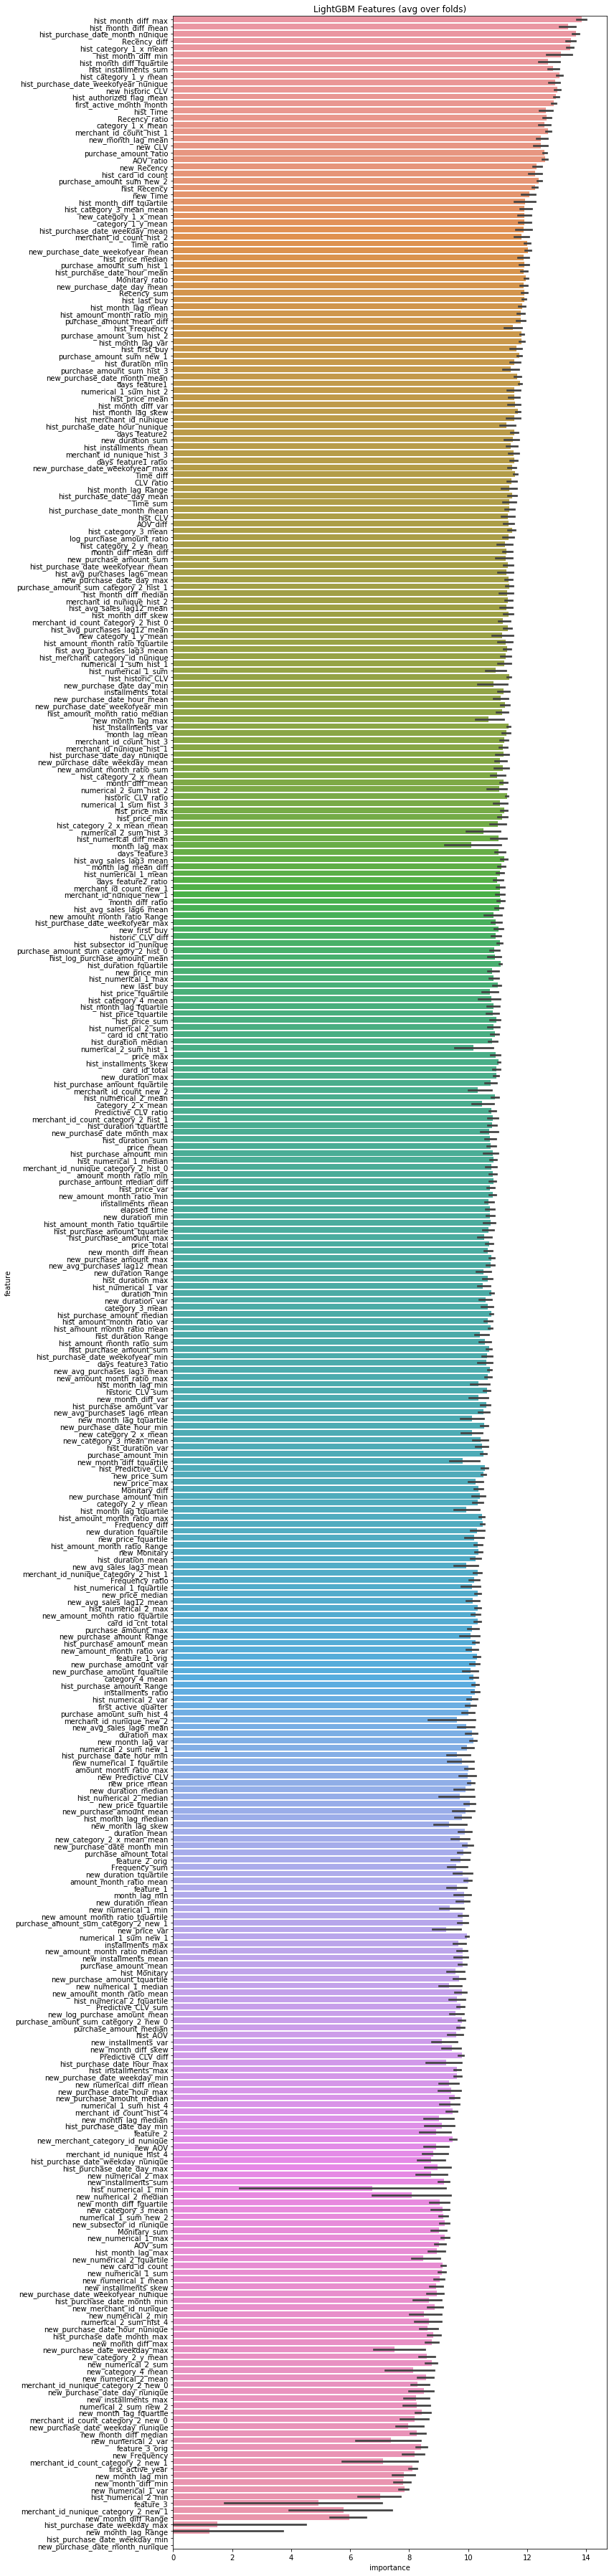

In [104]:
best_feautures = display_importances(feature_importance_df)

In [105]:
excl = ['new_purchase_date_month_nunique', 'hist_purchase_date_weekday_min']
sub_preds, feature_importance_df = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1))


Starting LightGBM. Train shape: (201917, 372), test shape: (123623, 372)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.62504	test's rmse: 3.69234
[200]	train's rmse: 3.51569	test's rmse: 3.65291
[300]	train's rmse: 3.44636	test's rmse: 3.63849
[400]	train's rmse: 3.39757	test's rmse: 3.63167
[500]	train's rmse: 3.35709	test's rmse: 3.62845
[600]	train's rmse: 3.32601	test's rmse: 3.62656
[700]	train's rmse: 3.29774	test's rmse: 3.62558
[800]	train's rmse: 3.27385	test's rmse: 3.62548
[900]	train's rmse: 3.25422	test's rmse: 3.62581
[1000]	train's rmse: 3.23614	test's rmse: 3.62559
[1100]	train's rmse: 3.2218	test's rmse: 3.62577
[1200]	train's rmse: 3.20849	test's rmse: 3.62591
Early stopping, best iteration is:
[769]	train's rmse: 3.28049	test's rmse: 3.62533
Fold  1 RMSE : 3.625329


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61678	test's rmse: 3.70845
[200]	train's rmse: 3.50571	test's rmse: 3.67553
[300]	train's rmse: 3.4361	test's rmse: 3.66421
[400]	train's rmse: 3.38401	test's rmse: 3.65975
[500]	train's rmse: 3.34509	test's rmse: 3.65823
[600]	train's rmse: 3.30778	test's rmse: 3.65807
[700]	train's rmse: 3.28183	test's rmse: 3.65789
[800]	train's rmse: 3.26001	test's rmse: 3.65747
[900]	train's rmse: 3.2394	test's rmse: 3.65744
[1000]	train's rmse: 3.22213	test's rmse: 3.65777
[1100]	train's rmse: 3.20727	test's rmse: 3.65794
[1200]	train's rmse: 3.19482	test's rmse: 3.65796
[1300]	train's rmse: 3.18585	test's rmse: 3.65815
Early stopping, best iteration is:
[839]	train's rmse: 3.25113	test's rmse: 3.65735
Fold  2 RMSE : 3.657353


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.61805	test's rmse: 3.70061
[200]	train's rmse: 3.50766	test's rmse: 3.66459
[300]	train's rmse: 3.44155	test's rmse: 3.65307
[400]	train's rmse: 3.39114	test's rmse: 3.64885
[500]	train's rmse: 3.35097	test's rmse: 3.64702
[600]	train's rmse: 3.31631	test's rmse: 3.64605
[700]	train's rmse: 3.28752	test's rmse: 3.64583
[800]	train's rmse: 3.26504	test's rmse: 3.64562
[900]	train's rmse: 3.24635	test's rmse: 3.64605
[1000]	train's rmse: 3.22693	test's rmse: 3.64616
[1100]	train's rmse: 3.20968	test's rmse: 3.64623
[1200]	train's rmse: 3.19727	test's rmse: 3.6463
Early stopping, best iteration is:
[783]	train's rmse: 3.26807	test's rmse: 3.64557
Fold  3 RMSE : 3.645568


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.6188	test's rmse: 3.70009
[200]	train's rmse: 3.50906	test's rmse: 3.66268
[300]	train's rmse: 3.43822	test's rmse: 3.65042
[400]	train's rmse: 3.38789	test's rmse: 3.6461
[500]	train's rmse: 3.34811	test's rmse: 3.64445
[600]	train's rmse: 3.31554	test's rmse: 3.64438
[700]	train's rmse: 3.28759	test's rmse: 3.64391
[800]	train's rmse: 3.26298	test's rmse: 3.64455
[900]	train's rmse: 3.24446	test's rmse: 3.64501
[1000]	train's rmse: 3.22428	test's rmse: 3.6451
[1100]	train's rmse: 3.2116	test's rmse: 3.64522
[1200]	train's rmse: 3.19856	test's rmse: 3.64555
Early stopping, best iteration is:
[716]	train's rmse: 3.28305	test's rmse: 3.64381
Fold  4 RMSE : 3.643812
RMSE is 3.6430333715988943


/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



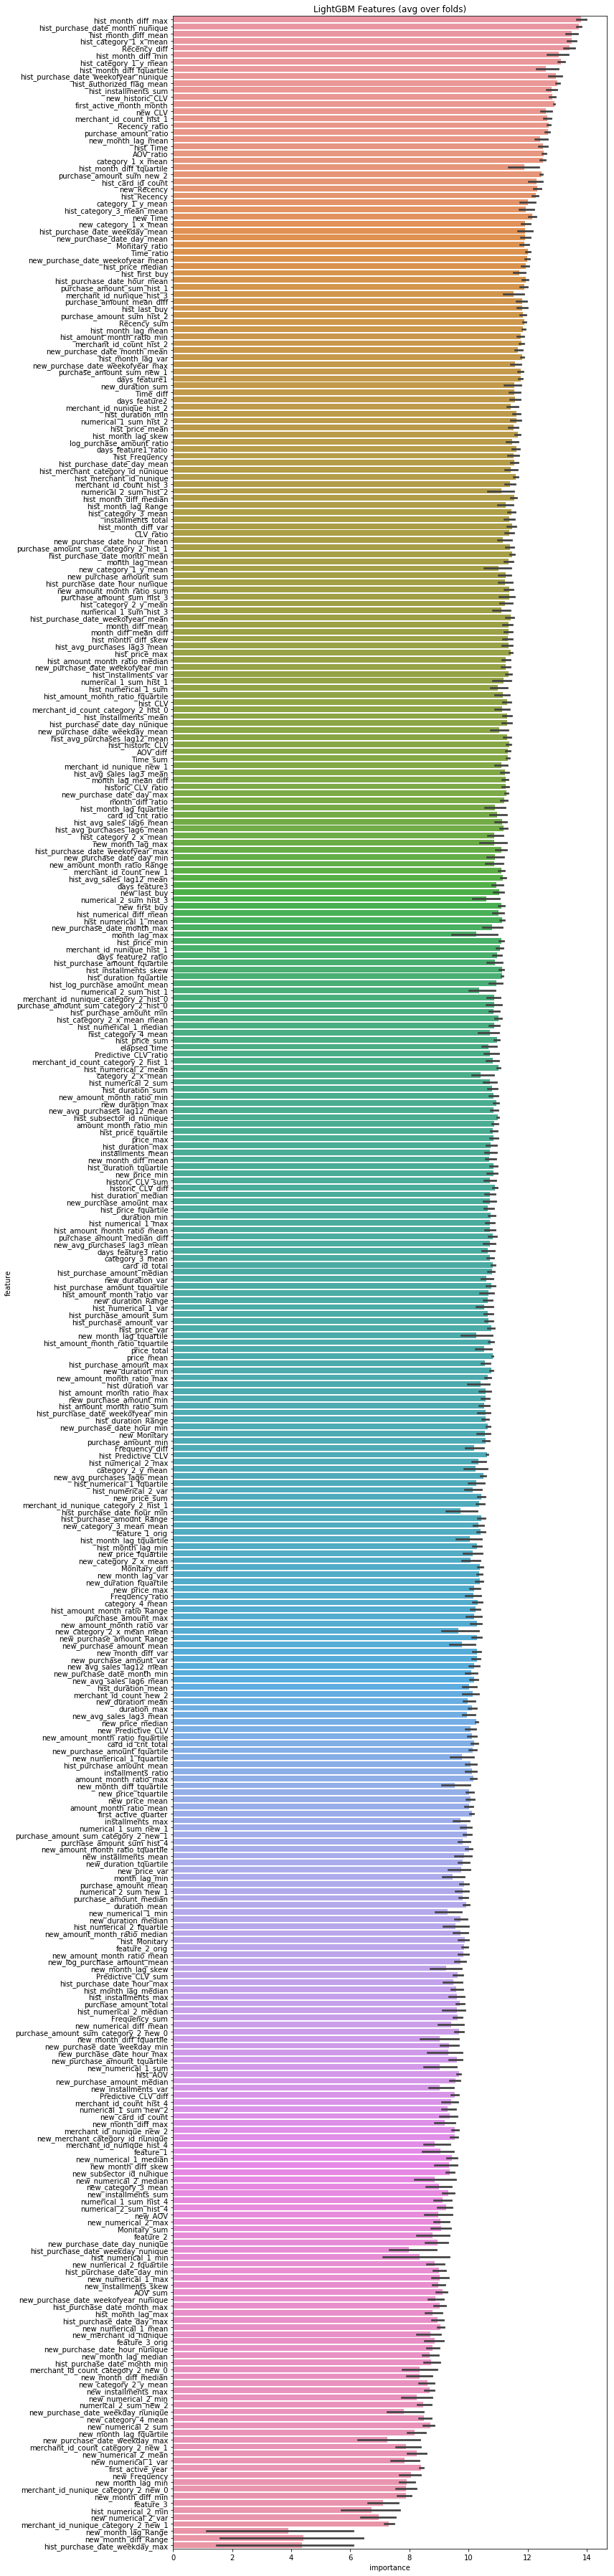

In [106]:
best_feautures = display_importances(feature_importance_df)

In [118]:
xsub = pd.DataFrame()
xsub['card_id']  = test_df['card_id']
xsub['target'] = sub_preds/4
xsub.to_csv('submission.csv', index = False)

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



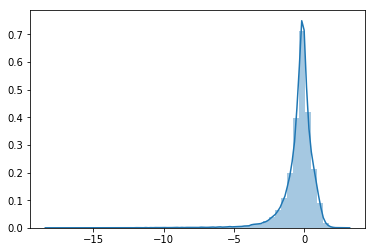

In [113]:
sns.distplot(sub_preds/4)

In [117]:
(sub_preds/4).max()

3.0440143048066934